# YOLOv3

YOLOv3 is one of the fastest object detection and recognitions algorithms in the field, relying largely on convolutional neural networks. It is in an improved iteration over its predecessors, YOLO and YOLOv2, featuring multiscale detection, a more robust feature extraction network, as well as some minor changes in its loss function. 

In comparison to traditional recognition algorithms, YOLOv3 is able to not only predict the class labels, but also detect the locations of multiple objects in an image too. The images are passed through a single neural network, divided into different regions, and then bounding box predictions weighted by predicted region probabilities are made on the input. This makes YOLOv3 an ideal candidate for real-time inference without having to compromise on accuracy. 


# Network Architecture 

The YOLOv3 network can be broken down into two principle components, namely the multiscale feature extractor, and the detector. Images are inputted into the network, passed through the feature extractor to obtain embedded features at multiple scales, and then the extracted features are fed into the detector in order to predict the location of bounding boxes and class information. 


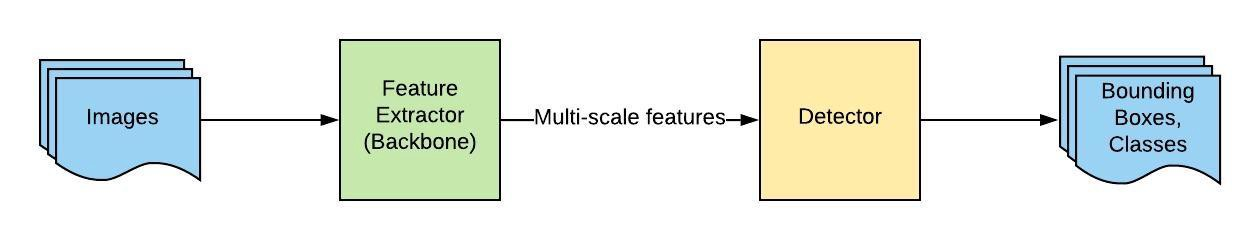

## Darknet 53

The YOLOv3 Darknet-53 feature extractor is a fully convolutional network made up of convolutional layers followed by batch normalisation layers and ReLU activations. It is an improvement on the previous implementation of Darknet-19 used in YOLO and YOLOv2, wherein Darknet-53 utilises skip connections to propagate activations through deeper layers without impacting gradients, allowing us to successfully extend the network from nineteen to fifty-three layers. This can be seen in the following diagram. 


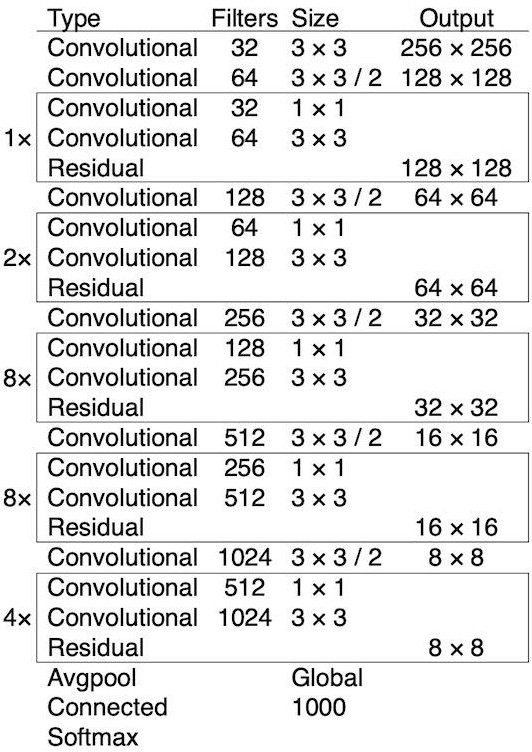

Each rectangular subsection in the diagram above can be thought of as a residual block. The entire network is simply a chain of these connected blocks with convolutional layers with a stride value of two in-between. These layers are used to downsample the feature maps by a factor of stride such as to prevent the loss of low-level features. Typically speaking, the stride of any layer in the network can be thought of as the factor by which the output of the layer is smaller than the input image to the network.


In the case of multiclass classification, the network shown above also utilises average pooling, fully-connected convolutional layers, and softmax activations. In the case of object detection, however, we instead append a detection head to the feature extractor at multiple scales. This allows us to use features from the last three residual blocks in our detection pipeline, allowing us to achieve multiscale detection and extract/detect smaller features embedding within the target image. 


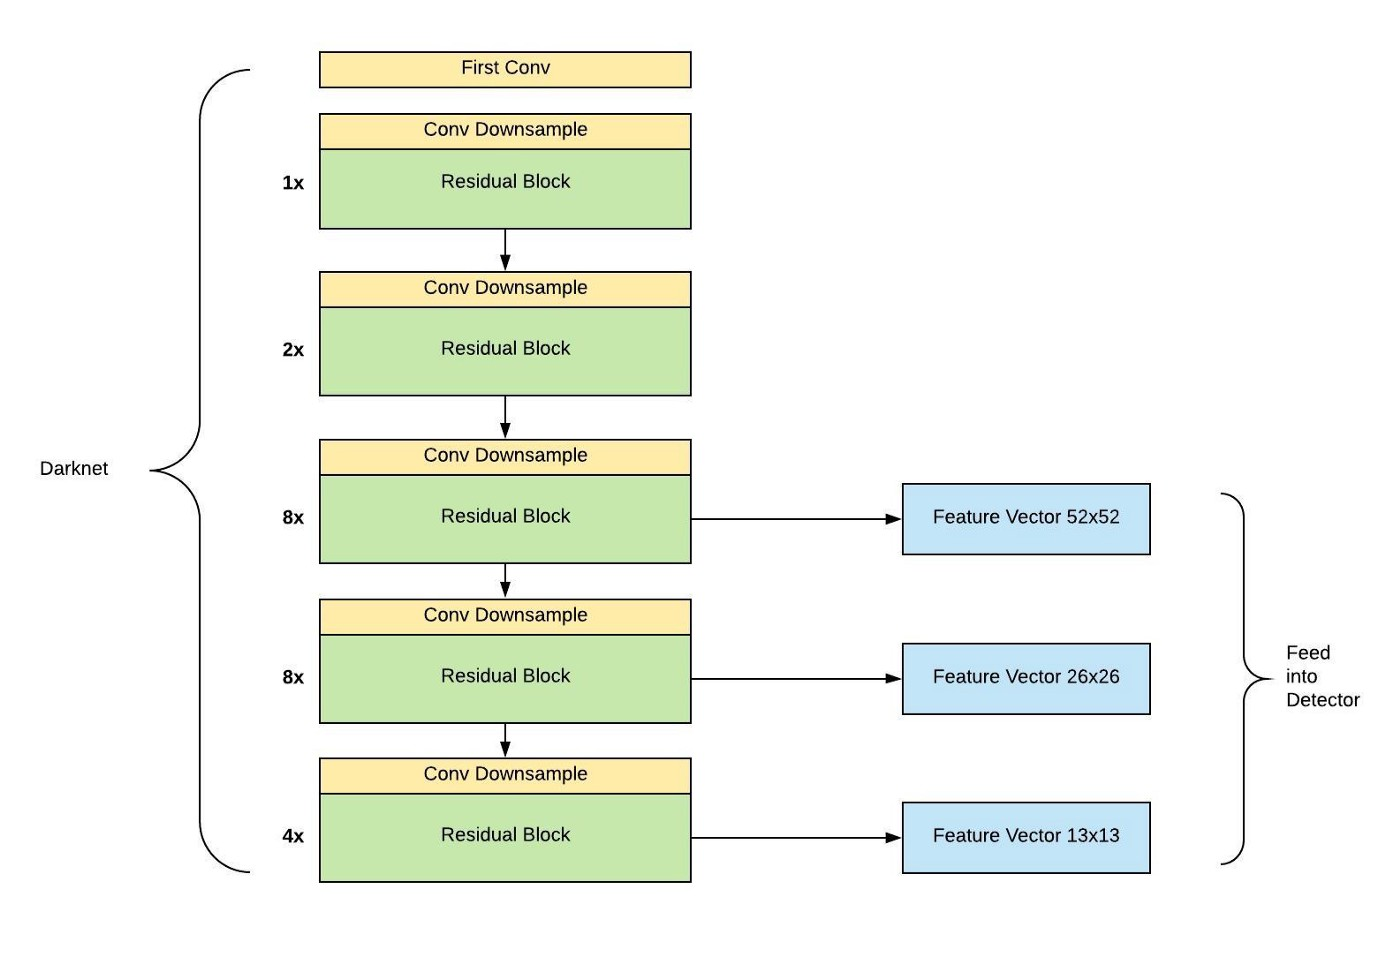

## Multiscale Detection

YOLOv3 makes predictions across multiple scales at feature maps of three different sizes, having strides 32, 16, and 8. The network downsamples the input image until the first detection layer, where a detection is made using feature maps of a layer with stride 32. Further, layers are upsampled by a factor of 2 and concatenated with feature maps of a previous layers having identical feature map sizes. Then another detection is now made at a layer with stride 16. The same upsampling procedure is repeated, and a final detection is made at the layer of stride 8. Each cell predicts 3 bounding boxes using 3 anchors for each scale. This helps YOLOv3 get better at detecting small objects as upsampling can help the network learn fine-grained features which are instrumental for detecting small objects.


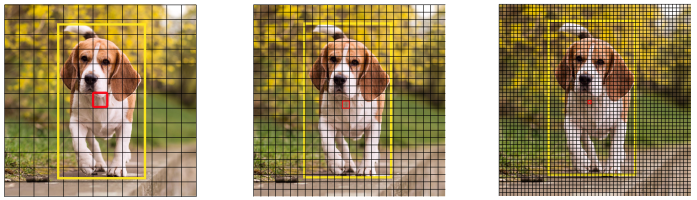

## Anchor Box

The goal of object detection is to extract bounding boxes and their corresponding class labels for objects found in a batch of input images. In order to compensate for the large variance in the scale and aspect-ratio of the boxes, we use anchor boxes to help us make predictions. In the context of object detection, an anchor box is a prior box with pre-defined aspect ratios determined prior to training. The anchor boxes are anchored to the output (square) matrix from the feature extractor, assigning anchor boxes to each cell in the grid such that they share the same centroid.  The anchor boxes allow us to then calculate the extent to which the ground truth boxes overlap with them and filter them out according to the highest IOU scores. This means that during our training, instead of predicting coordinates out of nowhere, we can instead predict offsets to the bounding boxes, along with objectness scores and class probabilities. In YOLOv3, we have three anchor boxes per grid cell, as well as three different scales. Therefore, we will have 52x52x3, 26x26x3, and 13x13x3 anchor boxes for each scale.



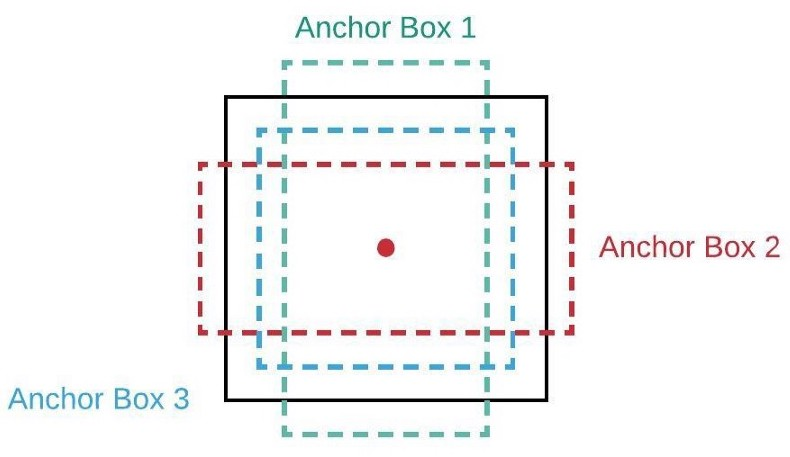

It is important to note that the objectness score simply represents the probability that an object is contained within a bounding box. It is passed through a sigmoid such that it can be interpreted as a probability. The class confidence, similarly, represents the probability of the detected object belonging to a particular class. It is also passed through a sigmoid, as opposed to a softmax function. The reason for this is that softmaxing class scores assumes that the classes are mutually exclusive. In simple words, if an object belongs to one class, then it's guaranteed it cannot belong to another class. This is true for COCO database on which we will base our detector, however, this assumptions may not hold when we have classes like man and person.


The calculated offsets mentioned above can later be applied to the anchor boxes to obtain the final prediction. The following formula describes how the network output is transformed to obtain bounding box predictions:


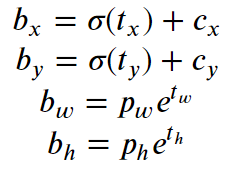

In the equations above, (𝑏𝑥, 𝑏𝑦, 𝑏𝑤, 𝑏ℎ) represent the the x and y centre coordinates, width, and height of our prediction, (𝑡𝑥, 𝑡𝑦, 𝑡𝑤, 𝑡ℎ) represent the network output/anchor box offsets, (𝑐𝑥, 𝑐𝑦) represent the top-left coordinates of the grid, and  (𝑝𝑤, 𝑝ℎ) are anchor dimensions for the box. 

It is also important to note that the centre coordinates are passed through a sigmoid function in order to force the output values within a zero-one range. This is because YOLO does not predict the absolute coordinates of the centre of the bounding box. Instead, it predicts the  offsets relative to the top left corner of the grid cell responsible for prediction and normalises them by the cell dimensions. This is to ensure that we do not break the theory behind YOLOv3. If we postulate that a certain cell is responsible for prediction and the predicted offsets are larger than one, then we end up assigning the centre to a cell that is not the predicting cell.


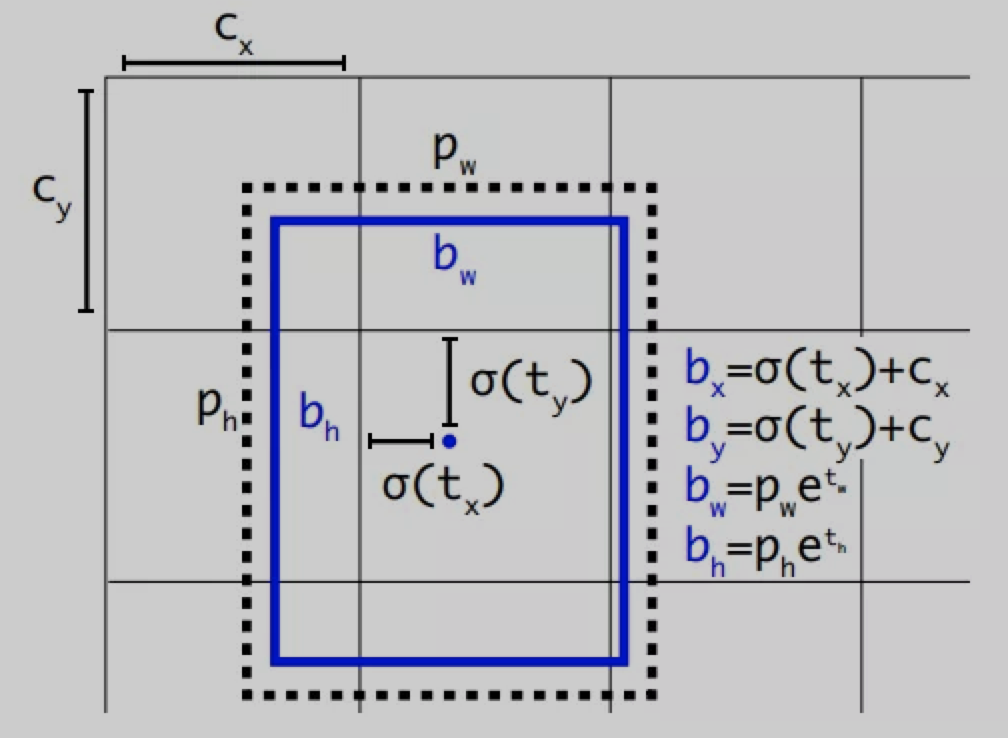

# Detection Output

In YOLOv3, we input a batch of images using a data loader and pass them through a feature extractor. The features learned by the convolutional layers are then passed onto a detector that makes predictions relating to the coordinates of the bounding box, class labels, and objectness scores. The output is then returned as a feature map of the same size as the feature map before it due to the use of 1x1 convolutional layers in the detection pipeline. 


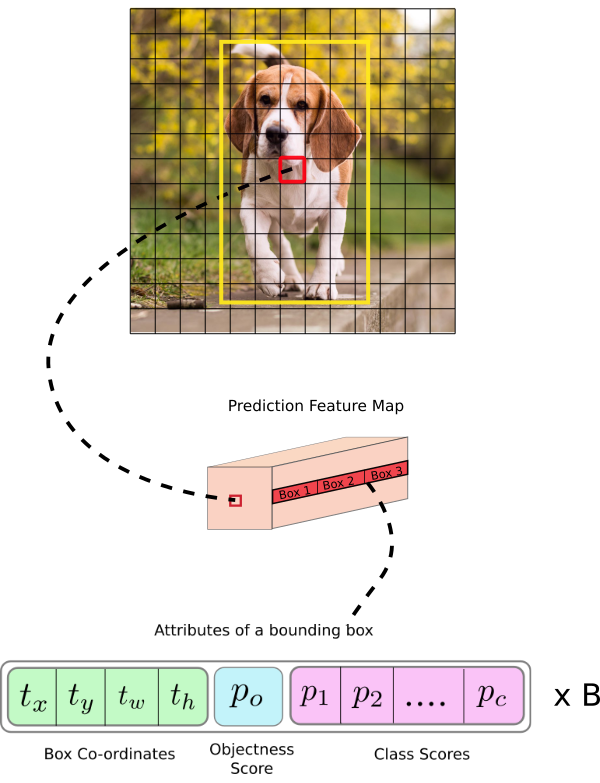

It is also important to note, as shown in the image above, that each bounding box contains 85 attributes pertaining to the boxes coordinates, the objectness score, as well as the class scores. 


In YOLOv3, we expect each cell in the feature map to predict an object through one of its three bounding boxes **iff** the centre of the object falls in the receptive field of the cell in question. This is because, during training, only one bounding box is responsible for detecting any given object. In order to achieve this, however, we must ascertain which of the cells this bounding box belongs to and so we divide input images into a grid of dimensions equal to that of the final feature map. The cell that contains the centre of the ground truth box of an object is then chosen to be the one responsible for making a prediction, and then we must determine which of that cell’s bounding boxes should be assigned to the ground truth label of the object in question based on the anchors. The bounding box responsible for detecting the dog will be the one whose anchor has the highest IoU with the ground truth box, as shown in the diagram below:

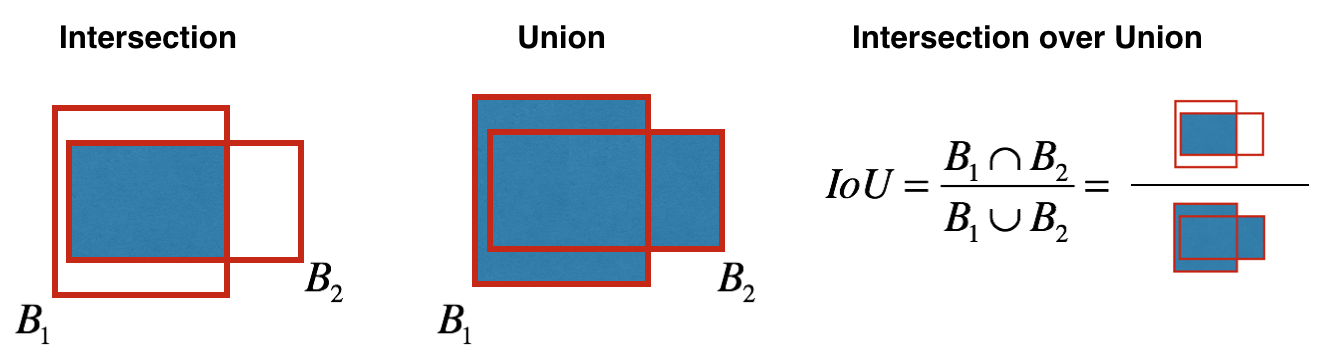

# Postprocessing

The final component of YOLOv3 is a post-processor that preforms non-maximum suppression in order to eliminate instances of multiple detections of the same object in an image.  

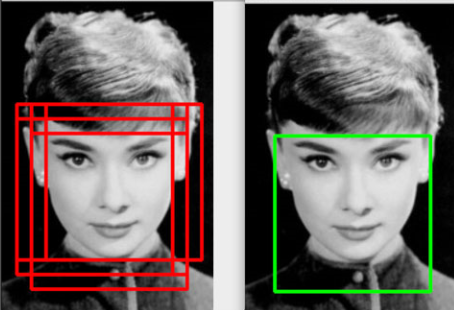

The idea being non-maximum suppression is quite simple and requires us to filter boxes based on their objectness scores being above a given threshold, and then calculate the IOU of the filtered boxes with all the others. The boxes with the highest IOU are removed and this process is repeated until there are no more boxes.  

# Install Requirements

In [1]:
# !pip install -r requirements.txt --user # !pip3 install -r requirements.txt --user

# Install Dataset

In [2]:
# %cd data

# !bash get_coco2017.sh

# Install Weights

In [3]:
# %cd ..

# %cd weights

# !wget https://pjreddie.com/media/files/yolov3.weights
    
# %cd ..

# Import Libraries 

In [4]:
import torch.backends.cudnn as cudnn
import glob
import random
import shutil
import subprocess
import time
import cv2
import matplotlib
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
import os
import numpy as np
import math
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.backends.cudnn as cudnn

In [5]:
from threading import Thread
from PIL import Image, ExifTags
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy
from tqdm import tqdm
from copy import copy
from pathlib import Path
from sys import platform
from IPython.display import Image, clear_output 

In [6]:
# set printoptions
torch.set_printoptions(linewidth = 320, precision = 5, profile ='long')
np.set_printoptions(linewidth = 320, formatter ={'float_kind': '{:11.5g}'.format})  # format short g, %precision = 5
matplotlib.rc('font', **{'size': 11})

# prevent OpenCV from multithreading in order to use PyTorch DataLoader
cv2.setNumThreads(0)


In [7]:
acceptedImageFormats = ['.bmp', '.jpg', '.jpeg', '.png', '.tif', '.tiff', '.dng']

# find the orientation of the exif tag
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break


# Datasets

## Load Images - Inference Dataset Interface

The following class is used to load images during inference. It works by extracting the files stored in a path and storing the images if they are in the correct format. It then also reads each image, resizes it, and converts it from BGR to RGB with a shape of 3x416x416.

In [8]:
class LoadImages: 
    def __init__(self, path, imageSize = 416):
        
        # init files list  
        files = []
        # extract path 
        path = str(Path(path))  
        
        # check if path leads to a directory  and populate files list
        if os.path.isdir(path):
            files = sorted(glob.glob(os.path.join(path, '*.*')))
        # check if path leads to a file and populate files list 
        elif os.path.isfile(path):
            files = [path]

        # extract image(s) if they are in the correct format 
        images = [x for x in files if os.path.splitext(x)[-1].lower() in acceptedImageFormats]
        # extract number of images
        numImages = len(images)
        # init image size 
        self.imgSize = imageSize
        # init files 
        self.files = images 
        # init number of files 
        self.numFiles = numImages 

    def __iter__(self):

        # init count to zero 
        self.count = 0

        return self

    def __next__(self):

        # check if we have loaded all of the images 
        if self.count == self.numFiles:
            raise StopIteration
        
        # extract path
        path = self.files[self.count]
        # increment count
        self.count += 1
        # read image
        img0 = cv2.imread(path)
        # resize by adding padding
        img = letterbox(img0, newShape = self.imgSize)[0]
        # convert image from BGR to RGB and to 3x416x416
        img = img[:, :, ::-1].transpose(2, 0, 1)
        img = np.ascontiguousarray(img)

        return path, img, img0

    def __len__(self):

        # return number of files
        return self.numFiles


## Load Images and Labels - Training and Testing Dataset Interface

The following class is used to load images and labels during training and testing. 

The **init** function works by extracting and caching the necessary images, labels, and shapes from their respective paths and also makes some slight modifications if rectangular training/inference is enabled. 

The main motivation behind rectangular inference is that it reduces the inference time proportionally to the amount of letterboxed area padded onto a square image. In a square image, there is a lot of redundant information in the form of padding, and as such rectangular inference removes much of this redundancy. It is important to note that rectangular inference is only used during detection and testing. It is not used during training, however, since images are loaded in batches and each image has a different aspect ratio. This can be accounted for by determining the batch index of each image apriori and then letterboxing all the images in the batch to the same size. This, however, will require turning off the shuffle parameter in the dataloader to prevent the order of data from being adjusted. 

The **getitem** function simply loads the image and performs augmentations and creates mosaics if/when needed. The augmentations that it applies include left/right flips and augmenting the hue, saturation, and value of the image. 

In [9]:
class LoadImagesAndLabels(Dataset): 
    def __init__(self, path, img_size=416, batch_size=16, augment=False, hyp=None, rect=False, pad=0.0):
        
        # extract path 
        path = str(Path(path))  
        # extract parent 
        parent = str(Path(path).parent) + os.sep

        # check if path leads to a file
        if os.path.isfile(path): 

            # read through file and adjust lines 
            with open(path, 'r') as f:
                f = f.read().splitlines()
                f = [x.replace('./', parent) if x.startswith('./') else x for x in f]  

        # check if path leads to a directory
        elif os.path.isdir(path): 
            f = glob.iglob(path + os.sep + '*.*')

        # raise error exception
        else:
            raise Exception('%s does not exist' % path)
                
        # extract image files if they are in the correct format 
        self.imgFiles = [x.replace('/', os.sep) for x in f if os.path.splitext(x)[-1].lower() in acceptedImageFormats]
        # extract label files
        self.labelFiles = [x.replace('images', 'labels').replace(os.path.splitext(x)[-1], '.txt') for x in self.imgFiles]

        # extract number of files
        numImageFiles = len(self.imgFiles)
        # extract batch index
        imageBatchIndex = np.floor(np.arange(numImageFiles) / batch_size).astype(np.int)  
        # extract number of batches
        numBatches = imageBatchIndex[-1] + 1  

        # init number of images 
        self.numFiles = numImageFiles
        # init image batch index 
        self.imageBatchIndex = imageBatchIndex  
        # init image size 
        self.imageSize = img_size
        # init augment bool
        self.isAugment = augment
        # init hyperparameters
        self.hyperparameters = hyp
        # init rect bool
        self.isRect = rect
        # init mosaic bool
        self.isMosaic = self.isAugment  and not self.isRect 
        # init shapefile path
        shapefilePath = path.replace('.txt', '') + '.shapes' 

        try:
            # read existing shapefile
            with open(shapefilePath, 'r') as f:  # read existing shapefile
                shapefile = [x.split() for x in f.read().splitlines()]
        except:
            # extract image shapes
            shapefile = [getEXIFsize(Image.open(f)) for f in tqdm(self.imgFiles, desc='reading image shapes')]
            # overwrite existing shapefile if it already exists
            np.savetxt(shapefilePath, shapefile, fmt='%g')  

        # init shapes array
        self.shapes = np.array(shapefile, dtype=np.float64)

        # check if rectangular training/inference
        if self.isRect:
            # extract image sahpe
            imgShape = self.shapes 
            # calculate image aspect ratio
            aspectRatio = imgShape[:, 1] / imgShape[:, 0]  
            # sort by aspect ratio and store sorted indices
            sortedRectangularIndices = aspectRatio.argsort()
            # init list of image files to be used 
            self.imgFiles = [self.imgFiles[index] for index in sortedRectangularIndices]
            # init list of label files to be used
            self.labelFiles = [self.labelFiles[index] for index in sortedRectangularIndices]
            # init shapes to be used
            self.shapes = imgShape[sortedRectangularIndices]  
            # init aspect ratios to be used
            aspectRatio = aspectRatio[sortedRectangularIndices]

            shapes = [[1, 1]] * numBatches

            # set image shapes for training 
            for index in range(numBatches):
                # extract aspect ratio indices
                aspectRatioIndices = aspectRatio[imageBatchIndex == index]
                # extract min and max indices
                minIndex, maxIndex = aspectRatioIndices.min(), aspectRatioIndices.max()

                # check if max index is smaller than one 
                if maxIndex < 1:
                    # modify shape
                    shapes[index] = [maxIndex, 1]

                # check if min index is larger than one
                elif minIndex > 1:
                    # modify shape
                    shapes[index] = [1, 1 / minIndex]

            self.batchShapes = np.ceil(np.array(shapes) * img_size / 32. + pad).astype(np.int) * 32

        # init image list 
        self.imgs = [None] * numImageFiles
        # init labels list
        self.labels = [np.zeros((0, 5), dtype=np.float32)] * numImageFiles
        # init bool to check if labels are already cached
        isLabelsLoaded = False
        # init numMissing, numFound, numDuplicate
        numMissing, numFound, numEmpty, numDuplicates = 0, 0, 0, 0  
        # init path to save/retrieve cached labels in .npy file
        cachedLabelsFile = str(Path(self.labelFiles[0]).parent) + '.npy' 
        
        # check if cached labels file exists
        if os.path.isfile(cachedLabelsFile):
            # load cached labels file
            x = np.load(cachedLabelsFile, allow_pickle=True)
            # check if number of cached labels is equal to total number of files/labels
            if len(x) == numImageFiles:
                # assign labels
                self.labels = x
                # set isLabelsLoaded to true 
                isLabelsLoaded = True

        # create a progress bar 
        progressBar = tqdm(self.labelFiles)
        
        # iterate through label files
        for index, file in enumerate(progressBar):
            
            # check if label is already loaded 
            if isLabelsLoaded:
                # assign current indexed label
                label = self.labels[index]
            else:
                try:
                    # open file
                    with open(file, 'r') as f:
                        # parse through file and assign to label
                        label = np.array([x.split() for x in f.read().splitlines()], dtype=np.float32)
                except:
                    # if except is triggered then this means we have a missing file/label and increment our count 
                    numMissing += 1  
                    continue
            
            # check if label is empty
            if label.shape[0]:
                # check if any duplicate rows
                if np.unique(label, axis=0).shape[0] < label.shape[0]:  
                    # if there are duplcicate rows then we have a duplicate file/label and increment our count 
                    numDuplicates += 1  

                # assing extracted label calue 
                self.labels[index] = label
                # increment our count of number of files found 
                numFound += 1  
            else:
                # increment our count of empty files
                numEmpty += 1

            # add descriptive values to progress bar             
            progressBar.desc = 'caching labels (%g found, %g missing, %g empty, %g duplicate, for %g images)' % ( numFound, numMissing, numEmpty, numDuplicates, numImageFiles)
        
        # if labels not cached already, save for next training
        if not isLabelsLoaded and numImageFiles > 1000:
            np.save(cachedLabelsFile, self.labels)  

    def __len__(self):
        return len(self.imgFiles)

    def __getitem__(self, index):
        
        #extract hyperparameters 
        hyperparameters = self.hyperparameters

        # check if isMosaic is true
        if self.isMosaic:
            # create mosaic and extract the tiled base image and corresponding labels
            img, labels = mosaic(self, index)
            shapes = None

        else:
            # load image 
            img, (originalHeight, originalWeight), (resizedHeight, resizedWidth) = loadImage(self, index)
            # extract image size 
            shape = self.batchShapes[self.batch[index]] if self.isRect else self.imageSize  
            # letterbox image and extract the letterboxed image, the scale ratio used, and padding
            img, ratio, pad = letterbox(img, shape, auto = False, scaleup = self.isAugment)
            # COCO mAP rescaling 
            shapes = (originalHeight, originalWeight), ((resizedHeight / originalHeight, resizedWidth / originalWeight), pad)  

            # init labels list
            labels = []
            # extract labels 
            x = self.labels[index]

            if x.size > 0:
                # make a copy of extracted labels 
                labels = x.copy()
                # normalize xywh to xyxy format
                labels[:, 1] = ratio[0] * resizedWidth * (x[:, 1] - x[:, 3] / 2) + pad[0]  
                labels[:, 2] = ratio[1] * resizedHeight * (x[:, 2] - x[:, 4] / 2) + pad[1]  
                labels[:, 3] = ratio[0] * resizedWidth * (x[:, 1] + x[:, 3] / 2) + pad[0]
                labels[:, 4] = ratio[1] * resizedHeight * (x[:, 2] + x[:, 4] / 2) + pad[1]

        # check if isAugment is true 
        if self.isAugment:
            # check if isMosaic is true 
            if not self.isMosaic:
                img, labels = randAffine(img, labels, degrees = hyperparameters['degrees'], translate = hyperparameters['translate'], scale = hyperparameters['scale'], shear = hyperparameters['shear'])
            # augment image/color space
            augmentHSV(img, hgain = hyperparameters['hsv_h'], sgain = hyperparameters['hsv_s'], vgain = hyperparameters['hsv_v'])
        
        # check if labels is not empty 
        if len(labels) :
            # convert xyxy to xywh
            labels[:, 1:5] = xyxy2xywh(labels[:, 1:5])
            # normalize height 
            labels[:, [2, 4]] /= img.shape[0]  
            # normalize width 
            labels[:, [1, 3]] /= img.shape[1]  

        # check if isAugment is true 
        if self.isAugment:
            # randomly preform left/right flip  on image
            if random.random() < 0.5:
                img = np.fliplr(img)
                # flip labels 
                if len(labels) :
                    labels[:, 1] = 1 - labels[:, 1]

        # init output labels 
        outputLabels = torch.zeros((len(labels) , 6))
        
        # check if labels is not empty 
        if len(labels):
            # populate output labels 
            outputLabels[:, 1:] = torch.from_numpy(labels)

        # convert from BGR to RGB and reshape to 3x416x416
        img = img[:, :, ::-1].transpose(2, 0, 1)  
        img = np.ascontiguousarray(img)

        return torch.from_numpy(img), outputLabels, self.imgFiles[index], shapes

    @staticmethod
    def collate_fn(batch):
        # extract image, label, path, shapes 
        img, label, path, shapes = zip(*batch)  

        # iterate through labels 
        for i, l in enumerate(label):
            # prepend target image index 
            l[:, 0] = i

        return torch.stack(img, 0), torch.cat(label, 0), path, shapes



## Get EXIF Size - Dataset Helper

The following function is called to return the EXIF-corrected PIL size for an input image. It works by extracting the shape, checking the orientation, and modifying the shape accordingly. The img._getexif() method is used to return a dictionary indexed by EXIF numeric tags.

In [10]:
def getEXIFsize(img):

    #extract image size
    shape = img.size
    try:        
        # rotation by 270
        if dict(img._getexif().items())[orientation] == 6:
            shape = (shape[1], shape[0])
        # rotation by 90
        elif dict(img._getexif().items())[orientation] == 8:
            shape = (shape[1], shape[0])    
    except:
        pass

    return shape

## Load Image - Dataset Helper: 

The purpose of the following function is to load a single image from the COCO dataset. The function works by extracting the image path and reading it using the cv2.imread() method. The cv2.imread() method loads an image from the specified file. If the image cannot be read (because of missing file, improper permissions, unsupported or invalid format) then this method returns an empty matrix. The height and width of the image are then extracted and we calculate the resize factor such that we can resize the image to a preset image size. The resizing of the image is done using the cv2.resize() method with either bilinear interpolation, or alternatively a variation of a nearest-neighbour interpolation that resamples using the pixel area resolution. The function then returns the image, its height and width, as well as its resized height and width. 

In [11]:
def loadImage(self, index):

    # extract path 
    path = self.imgFiles[index]
    # read image 
    img = cv2.imread(path)  
    # extract height and width of image 
    originalHeight, originalWidth = img.shape[:2]  
    # resize factor so that we can resize image to imageSize
    resizeFactor = self.imageSize / max(originalHeight, originalWidth)
    
    # always resize down, only resize up if training with augmentation
    if resizeFactor != 1:
        # interpolate image
        interp = cv2.INTER_AREA if resizeFactor < 1 and not self.isAugment else cv2.INTER_LINEAR
        # resize image
        img = cv2.resize(img, (int(originalWidth * resizeFactor), int(originalHeight * resizeFactor)), interpolation = interp)
    
    # extract height and width of resized image 
    resizedHeight, resizedWidth = img.shape[:2]

    return img, (originalHeight, originalWidth), (resizedHeight, resizedWidth) 

## Augment HSV - Dataset Helper

The following function is used to modify an input image in-place by manipulating its hue, saturation, and value. It is important to note that hue, saturation, and value are the main colour properties that allow us to distinguish between different colours. Modifying these values allows us to augment our input image, expand out dataset, and improve our training results.


1. The hue refers to the three primary colours (red, blue, and yellow) and the three secondary colours (orange, green, and violet) that appear in the colour wheel. It represents the visual spectrim of basic colours that can be seen in a rainbow.  


2. The saturation is the purity and intensity of a colour as displayed in an image. The higher the saturation of a colour, the more vivid and intense it is. The lower a colour’s saturation, or chroma, the closer it is to pure grey on the grayscale.


3. The value refers to the relative lightness or darkness of a colour based on the quantity of light reflected off of a surface and absorbed by the human eye. 


The cv2.LUT() method allows us to create a lookup-table with randomly generated values that are used to  transform the image’s hue, saturation, and value to new values. The image is then modified using cv2.cvtColor() to convert the image from one colour space to another.

The effects of this transformation can be seen in the figure below:

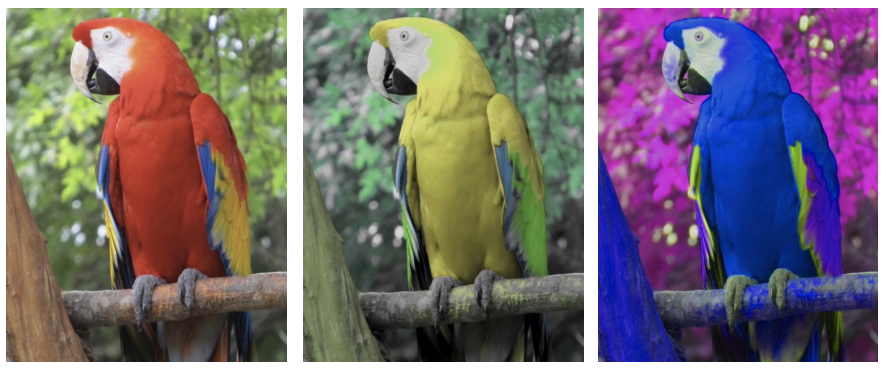

In [12]:
def augmentHSV(img, hgain = 0.5, sgain = 0.5, vgain = 0.5):
    
    # init random gains
    randomGains = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  
    # extract hue, saturation, value from image
    hue, sat, val = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    # init numpy array
    x = np.arange(0, 256, dtype = np.int16)
    # init look-up table for hue with random gain
    lookUpHue = ((x * randomGains[0]) % 180).astype(img.dtype)
    # init look-up table for saturation with random gain 
    lookUpSat = np.clip(x * randomGains[1], 0, 255).astype(img.dtype)
    # init look-up table for value with random gain
    lookUpVal = np.clip(x * randomGains[2], 0, 255).astype(img.dtype)
    # extract new hue, saturation, value for image using look-up tables
    modifiedHSV = cv2.merge((cv2.LUT(hue, lookUpHue), cv2.LUT(sat, lookUpSat), cv2.LUT(val, lookUpVal))).astype(img.dtype)
    # modify image
    cv2.cvtColor(modifiedHSV, cv2.COLOR_HSV2BGR, dst = img)  


## Mosaic - Dataset Helper

The following function is used to load images into a mosaic of four. It is a form of augmentation that is used only during training and it works by taking a total of four images, creating a base image with the corresponding number of tiles, and then calculating the position of each image on the base image. It also calculates the required padding, normalises the image labels, and then concatenates/clips the labels and applies an augmentation to both the images and labels, and returns them.

The effects of this transformation can be seen in the figure below:

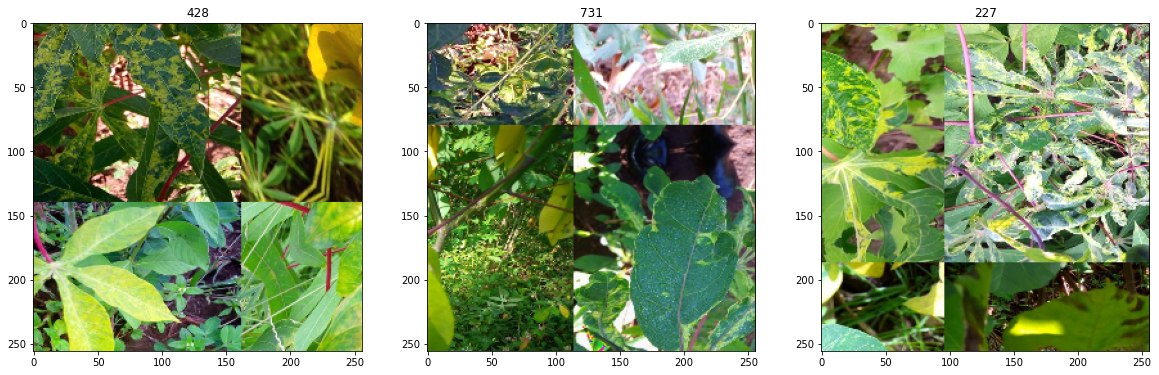

In [13]:
def mosaic(self, index):   

    # init labels 
    mosaicLabels = []
    # extract image size
    imageSize = self.imageSize
    # randomly init center coordinates
    centerX, centerY = [int(random.uniform(imageSize * 0.5, imageSize * 1.5)) for _ in range(2)]
    # randomly init an additional three image indices
    indices = [index] + [random.randint(0, len(self.labels) - 1) for _ in range(3)]
    
    for i, imageIndex in enumerate(indices):
        # load current image
        img, (originalHeight, originalWidth), (resizedHeight, resizedWidth) = loadImage(self, imageIndex)

        if i == 0: # top left
            # create base image with 4 tiles
            baseImage = np.full((imageSize * 2, imageSize * 2, img.shape[2]), 114, dtype = np.uint8)  
            # xmin, ymin, xmax, ymax for large image
            xMinlarge, yminLarge, xMaxLarge, yMaxLarge = max(centerX - resizedWidth, 0), max(centerY - resizedHeight, 0), centerX, centerY
            # xmin, ymin, xmax, ymax for small image
            xMinSmall, yMinSmall, xMaxSmall, yMaxSmall = resizedWidth - (xMaxLarge - xMinlarge), resizedHeight - (yMaxLarge - yminLarge), resizedWidth, resizedHeight  
        
        elif i == 1:  # top right
            # xmin, ymin, xmax, ymax for large image
            xMinlarge, yminLarge, xMaxLarge, yMaxLarge = centerX, max(centerY - resizedHeight, 0), min(centerX + resizedWidth, imageSize * 2), centerY
            # xmin, ymin, xmax, ymax for small image
            xMinSmall, yMinSmall, xMaxSmall, yMaxSmall = 0, resizedHeight - (yMaxLarge - yminLarge), min(resizedWidth, xMaxLarge - xMinlarge), resizedHeight
        
        elif i == 2: # bottom left
            # xmin, ymin, xmax, ymax for large image
            xMinlarge, yminLarge, xMaxLarge, yMaxLarge = max(centerX - resizedWidth, 0), centerY, centerX, min(imageSize * 2, centerY + resizedHeight)
            # xmin, ymin, xmax, ymax for small image
            xMinSmall, yMinSmall, xMaxSmall, yMaxSmall = resizedWidth - (xMaxLarge - xMinlarge), 0, max(centerX, resizedWidth), min(yMaxLarge - yminLarge, resizedHeight)
        
        elif i == 3: # bottom right
            # xmin, ymin, xmax, ymax for large image
            xMinlarge, yminLarge, xMaxLarge, yMaxLarge = centerX, centerY, min(centerX + resizedWidth, imageSize * 2), min(imageSize * 2, centerY + resizedHeight)
            # xmin, ymin, xmax, ymax for small image
            xMinSmall, yMinSmall, xMaxSmall, yMaxSmall = 0, 0, min(resizedWidth, xMaxLarge - xMinlarge), min(yMaxLarge - yminLarge, resizedHeight)

        # init base image parameters 
        baseImage[yminLarge:yMaxLarge, xMinlarge:xMaxLarge] = img[yMinSmall:yMaxSmall, xMinSmall:xMaxSmall]  
        
        # calculate padding 
        widthPadding = xMinlarge - xMinSmall
        heightPadding = yminLarge - yMinSmall

        # extract labels
        labels = self.labels[imageIndex]
        _labels = labels.copy()

        # normalize xywh to xyxy format
        if labels.size > 0:
            _labels[:, 1] = resizedWidth * (labels[:, 1] - labels[:, 3] / 2) + widthPadding
            _labels[:, 2] = resizedHeight * (labels[:, 2] - labels[:, 4] / 2) + heightPadding
            _labels[:, 3] = resizedWidth * (labels[:, 1] + labels[:, 3] / 2) + widthPadding
            _labels[:, 4] = resizedHeight * (labels[:, 2] + labels[:, 4] / 2) + heightPadding
        
        mosaicLabels.append(_labels)

    # check if mosaicLabels is not empty
    if len(mosaicLabels):
        # concatenate labels
        mosaicLabels = np.concatenate(mosaicLabels, 0)
        # clip labels
        np.clip(mosaicLabels[:, 1:], 0, 2 * imageSize, out = mosaicLabels[:, 1:])

    # augment images and labels
    baseImage, mosaicLabels = randAffine(baseImage, mosaicLabels,degrees = self.hyperparameters['degrees'], translate = self.hyperparameters['translate'], scale = self.hyperparameters['scale'], shear = self.hyperparameters['shear'], border = -imageSize // 2)  # border to remove

    return baseImage, mosaicLabels

## Letterbox - Dataset Helper 

The following function is used to resize an input image into a 32-pixel-multiple rectangle. This reduces  the inference time proportionally to the amount of letterboxed area padded onto a square image. It works by extracting the current shape, calculating the necessary padding, resizing it if necessary, and then creating and adding a border using the cv2.copyMakeBorder() method. It returns the letterboxed image, the scaling ratio, as well as the padding used.

The effects of this transformation can be seen in the figure below:

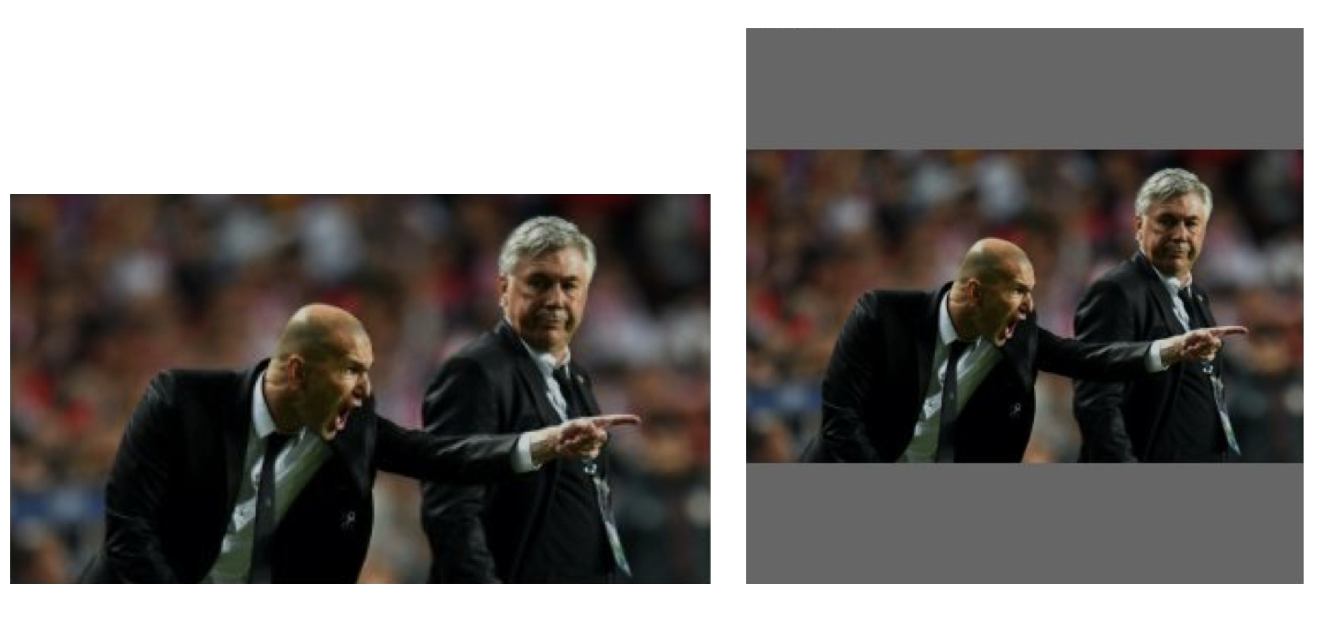

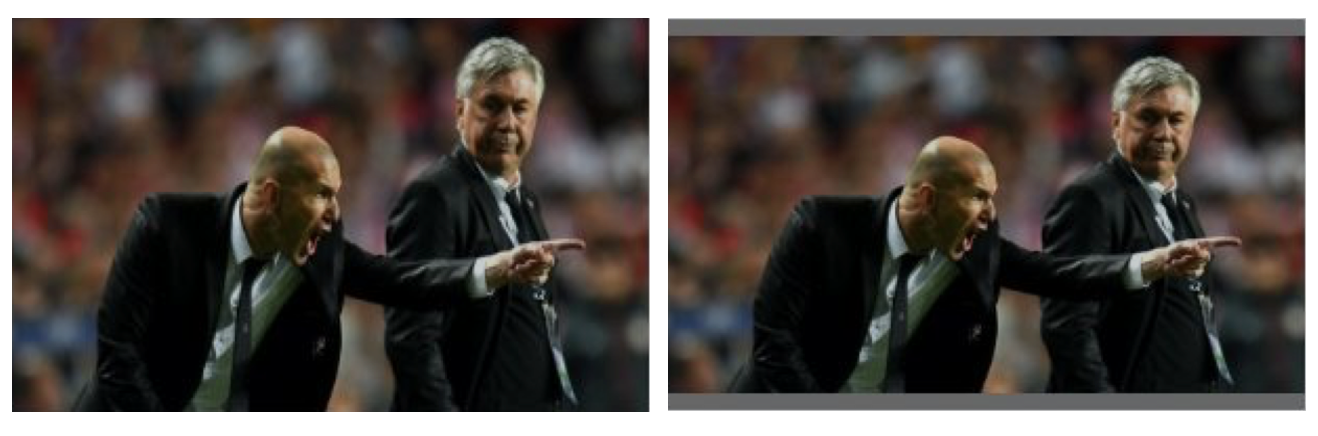

In [14]:
def letterbox(img, newShape = (416, 416), color = (114, 114, 114), auto = True, scaleFill = False, scaleup = True):

    # extract current image shape
    currShape = img.shape[:2]

    # check if new image shape is an integer or a tuple
    if isinstance(newShape, int):
        # create tuple
        newShape = (newShape, newShape)
    
    # calculate scale ratio by dividing new shape by old shape
    scaleRatio = min(newShape[0] / currShape[0], newShape[1] / currShape[1])

    # only scale down, do not scale up
    if not scaleup:
        scaleRatio = min(scaleRatio, 1.0)

    # extract unpadded shape
    unpaddedShape = (int(round(currShape[1] * scaleRatio)), int(round(currShape[0] * scaleRatio)))
    # calculate width and height padding 
    widthPadding, heightPadding = newShape[1] - unpaddedShape[0], newShape[0] - unpaddedShape[1]  
    
    if auto:  
        widthPadding, heightPadding = np.mod(widthPadding, 32), np.mod(heightPadding, 32)  # wh padding

    # resize image if current shape does not equal the unpadded shape 
    if currShape[::-1] != unpaddedShape:
        img = cv2.resize(img, unpaddedShape, interpolation = cv2.INTER_LINEAR)

    # divide width padding into two sides (left/right)
    widthPadding /= 2
    # divide height padding into two side (bottom/above)
    heightPadding /= 2
    # create top/bottom border
    top, bottom = int(round(heightPadding - 0.1)), int(round(heightPadding + 0.1))
    # create left/right border 
    left, right = int(round(widthPadding - 0.1)), int(round(widthPadding + 0.1))
    # add borders
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value = color)  

    return img, (scaleRatio, scaleRatio), (widthPadding, heightPadding)

## Random Affine - Dataset Helper

The following function is another form of dataset augmentation used to apply rotate, scale, translate, and shear transforms to an input image. It also transforms the label coordinates and returns the image and label coordinates. The following figure explains  the differences between the affine transformations:

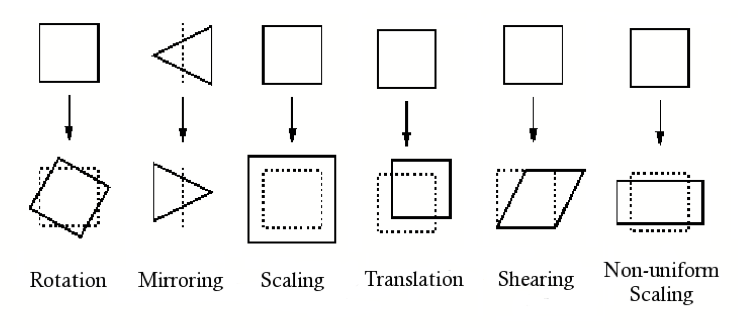

It works by creating and initialising a rotate/scale matrix, a translate matrix, and a shear matrix. These matrices are then combined to create a combined rotation matrix. 

The function then checks if the image needs to be changed and applies the cv2.warpAffine method with linear interpolation. This function applies an affine transformation to the image. It then transforms the label coordinates by first warping the coordinates, creating new boxes and filtering out warped points outside of the image bounds.

The effects of the affine transformation can be seen in the figure below:

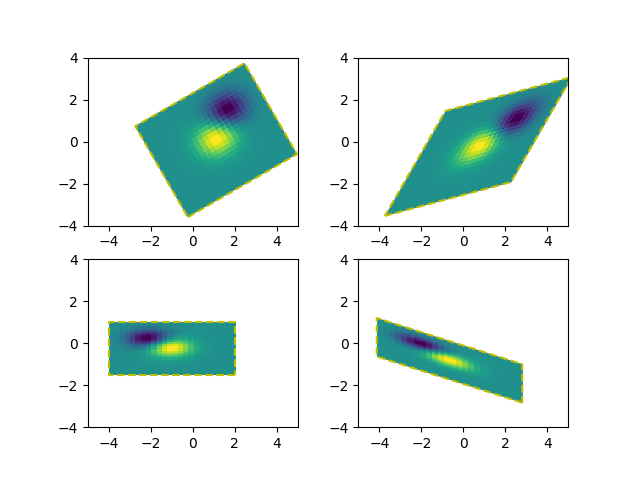

In [15]:
def randAffine(img, targets =(), degrees = 10, translate =.1, scale =.1, shear = 10, border = 0):

    constVal = 1e-16
    
    # calculate height
    height = img.shape[0] + border * 2
    # calculate width 
    width = img.shape[1] + border * 2

    # rotate and scale by first creating 3x3 identity matrix 
    R = np.eye(3)
    # init random angle value 
    angle = random.uniform(-degrees, degrees)
    # init random scale valye 
    scale = random.uniform(1 - scale, 1 + scale)
    # create rotation matrix
    R[:2] = cv2.getRotationMatrix2D(angle = angle, center =(img.shape[1] / 2, img.shape[0] / 2), scale = scale)

    # translate by first creating 3x3 identity matrix
    T = np.eye(3)
    # init x translation
    T[0, 2] = random.uniform(-translate, translate) * img.shape[0] + border  
    # init y translation
    T[1, 2] = random.uniform(-translate, translate) * img.shape[1] + border  

    # shear by first creating 3x3 identity matrix
    S = np.eye(3)
    # init x shear [deg]
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  
    # init y shear [deg] 
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  

    # creatte combined rotation matrix
    M = S @ T @ R

    # check if image changed
    if (border != 0) or (M != np.eye(3)).any():
        img = cv2.warpAffine(img, M[:2], dsize = (width, height), flags = cv2.INTER_LINEAR, borderValue = (114, 114, 114))

    # transform label coordinates
    if len(targets):

        # warp points
        xy = np.ones((len(targets) * 4, 3))
        xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(len(targets) * 4, 2)  # x1y1, x2y2, x1y2, x2y1
        xy = (xy @ M.T)[:, :2].reshape(len(targets), 8)

        # create new boxes
        x = xy[:, [0, 2, 4, 6]]
        y = xy[:, [1, 3, 5, 7]]
        xy = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, len(targets)).T

        # reject warped points outside of image
        xy[:, [0, 2]] = xy[:, [0, 2]].clip(0, width)
        xy[:, [1, 3]] = xy[:, [1, 3]].clip(0, height)
        
        # extract width
        w = xy[:, 2] - xy[:, 0]
        # extract height
        h = xy[:, 3] - xy[:, 1]

        # calculate area 
        area = w * h
        area0 = (targets[:, 3] - targets[:, 1]) * (targets[:, 4] - targets[:, 2])
        
        # calculate aspect ratio
        aspectRatio = np.maximum(w/(h + constVal), h/(w + constVal))  
        
        i = (w > 4) & (h > 4) & (area / (area0 * scale + constVal) > 0.2) & (aspectRatio < 10)

        targets = targets[i]
        targets[:, 1:5] = xy[i]

    return img, targets

# General Helper Methods

## XYXYtoXYWH

The following function converts boxes from  (x1, y1, x2, y2) to (x, y, w, h) where x1, y1 represent the top-left coordinates and x2, y2 represent the bottom-right coordinates. 


In [16]:
# convert boxes from [x1, y1, x2, y2] to [x, y, w, h] where x1, y1 represents the top-left coordinates and x2, y2 represents the bottom-right
def xyxy2xywh(x):
    y = torch.zeros_like(x) if isinstance(x, torch.Tensor) else np.zeros_like(x)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # center x coordinate
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # center y coordinate
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y

## XYWHtoXYXY

The following function, similarly to the above, converts boxes from (x, y, w, h) to (x1, y1, x2, y2) where x1, y1 represent the top-left coordinates and x2, y2 represent the bottom-right coordinates.


In [17]:
# convert boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1 = top-left, xy2 = bottom-right
def xywh2xyxy(x):
    y = torch.zeros_like(x) if isinstance(x, torch.Tensor) else np.zeros_like(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top-left x coordinate
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top-left y coordinate
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom-right x coordinate
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom-right y coordinate
    return y

## Scale Coordinates

The following function is used to rescale the coordinates extracted from the shape of img1 to that of the shape of img0. It works by calculating the gain and width/height padding required and then rescaling the coordinates and clipping the bounding boxes to the image’s shape using the torch.clamp() method.


In [18]:
# rescale coordinates from first shape to that of second shape 
def scaleCoordinates(img1_shape, coords, img0_shape, ratio_pad = None):
    
    # check if ratioPad is set to None
    if ratio_pad is None:  
        # calculate gain (old/new) from img0_shape
        gain = max(img1_shape) / max(img0_shape) 
        # calculate width and height padding from img0_shape
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2 
    
    else:
        # calculate gain from ratioPad
        gain = ratio_pad[0][0]
        # calculate padding from ratioPad 
        pad = ratio_pad[1]

    # extract x and y padding valyes 
    xPadding, yPadding = pad[0], pad[1]

    # rescale coordinates
    coords[:, [0, 2]] -= xPadding 
    coords[:, [1, 3]] -= yPadding  
    coords[:, :4] /= gain

    # clip bounding xyxy bounding boxes to image shape (height, width)
    coords[:, 0].clamp_(0, img0_shape[1])  # x1
    coords[:, 1].clamp_(0, img0_shape[0])  # y1
    coords[:, 2].clamp_(0, img0_shape[1])  # x2
    coords[:, 3].clamp_(0, img0_shape[0])  # y2

    return coords

## Scale Image

The following function is used to scale an input image. It works by extracting the width and height of the original image, calculating the new size it needs to be scaled to and resizing the image using torch.nn.functional.interpolate(). This function XX. The image is then padded using torch.nn.functional.pad and returned. 

In [19]:
def scaleImage(img, ratio = 1.0, same_shape = True):  # img(16,3,256,416), r = ratio
    
    # extract width and height 
    height, width = img.shape[2:]
    # calculate new size 
    newSize = (int(height * ratio), int(width * ratio))  
    # resize image
    img = F.interpolate(img, size = newSize, mode ='bilinear', align_corners = False)  
    
    # check if isSameShape set to false 
    if not same_shape:
        # calculate height and wdith to be used for padding/cropping image
        gridSize = 64  
        height, width = [math.ceil(x * ratio / gridSize) * gridSize for x in (height, width)]
        
    # pad image 
    return F.pad(img, [0, width - newSize[1], 0, height - newSize[0]], value = 0.447)  

## Average Precion Per Class

The following function computes the average for each class using precision using recall and precision curves. It takes in a numpy array of true positives, objectness values, predicted object classes, and true object classes in order to return the average precision on a class by class basis. More information about this function can be found here: https://github.com/rafaelpadilla/Object-Detection-Metrics.

It works by first sorting by objectness and extracting the sorted indices, extracting unique classes, and iterating through each class stored in unique classes and finding the number of ground truth and predicted objects. If these values are larger than 0, we accumulate the false/true positives and use them to create the recall and precision curves. These curves allow us to then calculate AP and F1 values. 

The precision is the ability of a model to identify only the relevant objects. It is the percentage of correct positive predictions and is given by the following equation:

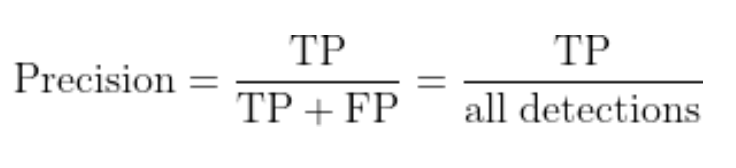

The recall is the ability of a model to find all the relevant cases (all ground truth bounding boxes). It is the percentage of true positive detected among all relevant ground truths and is given by the following equation:

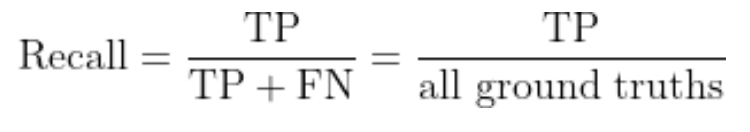

The F1 value is simply the harmonic mean of the precision and recall values and is given by the following equation: 

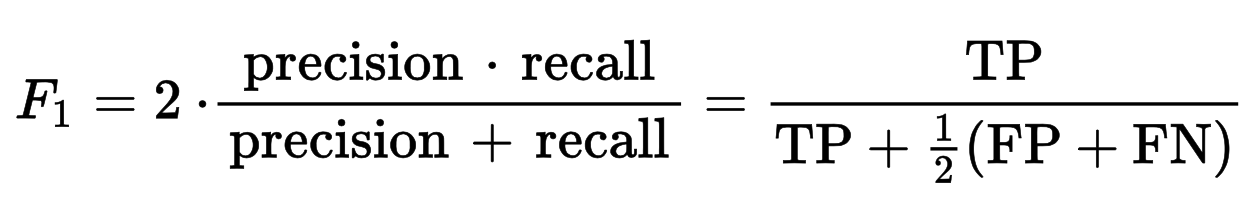

In the equations above, TP refers to true positives that represent a correct detection in which the IoU is larger than or equal to the thresholding value. FP refers to false positvies that represent an incorrect detection in which the IoU is smaller than the thresholding value. Similarly, FN refers to false negatives where a ground truth box is not detected.

The precision-recall curve is a good way to evaluate the performance of an object detector as the confidence is changed by plotting a curve for each object class. The object detector for a particular class is considered good if its precision stays high as recall increases, which means that if you vary the confidence threshold, the precision and recall will still be high. It is also worthwhile to evaluate detectors on how many false positives and negatives it records. 

The precision-recall curve essentially shows the tradeoff between precision and recall for different thresholds. This means that a high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall). In contrast to this, however, a system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels, whereas a system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. The ideal system with high precision and high recall will return many results, with all results labeled correctly.


The average precision (AP) is another way to compare the performance of an object detectors by calculating the area under the precision-recall curve. This is explored in slightly more detail in the next section. 

In [20]:
def getAPClass(truePositives, objectnessVal, predictedClasses, targetClasses):

    # sort by objectness and store sorted indices in objectnessSortIndices
    objectnessSortIndices = np.argsort(-objectnessVal)
    # sort truePositive using sorted indices
    truePositives = truePositives[objectnessSortIndices]
    # sort objectnessVal using sorted indices
    objectnessVal = objectnessVal[objectnessSortIndices]
    # sort predClasses using sorted indices
    predictedClasses = predictedClasses[objectnessSortIndices]
    # find all unique classes 
    uniqueClasses = np.unique(targetClasses)
    # init constant val
    constVal = 1e-16

    # score to evaluate P and R https://github.com/ultralytics/yolov3/issues/898
    precisionScore = 0.1  
    shape = [uniqueClasses.shape[0], truePositives.shape[1]]  # number class, number iou thresholds (i.e. 10 for mAP0.5...0.95)
    AP, precision, recall = np.zeros(shape), np.zeros(shape), np.zeros(shape)

    # iterate through each class stored in unique classes
    for classIndex, uniqueClass in enumerate(uniqueClasses):
        objectnessSortIndices = predictedClasses == uniqueClass
        # find number of ground truth objects
        numGroundTruthObjects = (targetClasses == uniqueClass).sum() 
        # find number of predicted objects 
        numPredictedObjects = objectnessSortIndices.sum()  

        # if there are no predicted objects AND no ground truth objects then we just skip this loop 
        if numPredictedObjects == 0 or numGroundTruthObjects == 0:
            continue
        
        # otherwise if both number of predicted objects and number of ground truth objects are both non-zero
        else:
            # find the cumulative sum of false positives 
            cumulativeFalsePositives = (1 - truePositives[objectnessSortIndices]).cumsum(0)
            # find the cumulative sum of true positives
            cumulativeTruePositives = truePositives[objectnessSortIndices].cumsum(0)

            # create the recall curve and append it to list
            recallCurve = cumulativeTruePositives / (numGroundTruthObjects + constVal)  
            # calculate recall at precisionScore
            recall[classIndex] = np.interp(-precisionScore, -objectnessVal[objectnessSortIndices], recallCurve[:, 0]) 

            # create the precision curve and append it to list
            precisionCurve = cumulativeTruePositives / (cumulativeTruePositives + cumulativeFalsePositives)  
            # calculate precision at precisionScore
            precision[classIndex] = np.interp(-precisionScore, -objectnessVal[objectnessSortIndices], precisionCurve[:, 0]) 

            # calculate AP from recall-precision curve
            for j in range(truePositives.shape[1]):
                AP[classIndex, j] = getAP(recallCurve[:, j], precisionCurve[:, j])

    # calculate F1 score
    F1 = 2 * precision * recall / (precision + recall + constVal)

    return precision, recall, AP, F1, uniqueClasses.astype('int32')

## Average Precision

The following function works alongside the function above. It takes in the recall and precision curves in order to calculate and return the average precision. More information about this function can be found here: https://github.com/rbgirshick/py-faster-rcnn.

It works by appending sentinel values to the beginning and end of the recall/precision lists, and then computing the precision envelope and integrating the area under the curve. The result of this integration is the average precision and is returned. 


In [21]:
def getAP(recall, precision):

    # append sentinel values at the beginning and end of the recall curve and precision curve
    mrec = np.concatenate(([0.], recall, [min(recall[-1] + 1E-3, 1.)]))
    mpre = np.concatenate(([0.], precision, [0.]))
    # calculate the precision envelope
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))
    # init a 101-point interp (COCO)
    x = np.linspace(0, 1, 101)
    # integrate area under envelope to calculate average precision
    AP = np.trapz(np.interp(x, mrec, mpre), x)

    return AP

## Intersection over Union (IOU)

The following function returns the IoU of two boxes. It works by extracting the coordinates of the bounding boxes, calculating the coordinates of the intersection rectangles, and using that to find the intersection area. The union area is then calculated using the width and height of the two boxes and the IoU is returned. 

The IoU is a measure based on the Jaccard Index that evaluates the overlap between two bounding boxes. It requires a ground truth bounding box  and a predicted bounding box, and by applying the IOU we can tell if a detection is valid (true positive) or not (false positive). It is given by the overlapping area between the predicted bounding box and the ground truth bounding box divided by the area of union between them. This can be seen in the following figure:

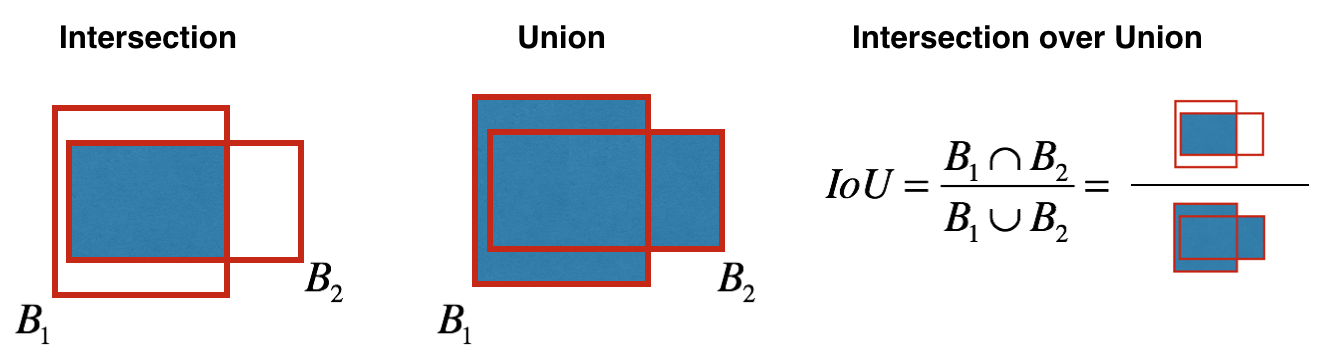

It is also important to note, however, that whilst boxIOU and widthHeightIOU  all carry out a similar role to boundingBoxIOU, boxIOU expects that the two sets of boxes are in (x1, y1, x2, y2) format, whereas widthHeightIOU returns an NxM IoU matrix. 

In [22]:
# returns the IoU of box1 to box2. box1 is 4, box2 is nx4
def boundingBoxIOU(firstBox, secondBox, x1y1x2y2 = True, GIoU = False):
    
    # transpose secondBox
    secondBox = secondBox.t()
    # init const val 
    constVal = 1e-16

    if x1y1x2y2:
        # extract coordinates of bounding boxes - transform from center and width to exact coordinates
        firstBoxX1, firstBoxY1 = firstBox[0], firstBox[1]
        firstBoxX2, firstBoxY2 = firstBox[2], firstBox[3]
        secondBoxX1, secondBoxY1 = secondBox[0], secondBox[1]
        secondBoxX2, secondBoxY2 = secondBox[2], secondBox[3]

    else:  
        # extract coordinates of bounding boxes - transform from xywh to xyxy
        firstBoxX1, firstBoxX2 = firstBox[0] - firstBox[2] / 2, firstBox[0] + firstBox[2] / 2
        firstBoxY1, firstBoxY2 = firstBox[1] - firstBox[3] / 2, firstBox[1] + firstBox[3] / 2
        secondBoxX1, secondBoxX2 = secondBox[0] - secondBox[2] / 2, secondBox[0] + secondBox[2] / 2
        secondBoxY1, secondBoxY2 = secondBox[1] - secondBox[3] / 2, secondBox[1] + secondBox[3] / 2

    # extract intersection rectangle coordinates
    rectIntersectionX1, rectIntersectionY1  = torch.max(firstBoxX1, secondBoxX1), torch.max(firstBoxY1, secondBoxY1) 
    rectIntersectionX2, rectIntersectionY2 = torch.min(firstBoxX2, secondBoxX2), torch.min(firstBoxY2, secondBoxY2)
    
    # calculate intersection width
    intersectionWidth = (rectIntersectionX2 - rectIntersectionX1).clamp(0)
    # calculate intersection height
    intersectionHeight = (rectIntersectionY2 - rectIntersectionY1).clamp(0)
    # calculate intersection area 
    intersectionArea = intersectionWidth * intersectionHeight

    # calculate width and height of first box 
    firstWidth, firstHeight = firstBoxX2 - firstBoxX1, firstBoxY2 - firstBoxY1
    # calculate width and height of second box 
    secondWidth, secondHeight = secondBoxX2 - secondBoxX1, secondBoxY2 - secondBoxY1
    # calculate union area 
    unionArea = (firstWidth * firstHeight + constVal) + secondWidth * secondHeight - intersectionArea

    # calculate intersection-over-union (IoU) area
    iou = intersectionArea / unionArea  
    
    # check if GIoU is true 
    if GIoU:
        # extract smallest enclosing width (convex width)
        smallestEnclosingWidth = torch.max(firstBoxX2, secondBoxX2) - torch.min(firstBoxX1, secondBoxX1)  
        # extract smallest enclosing height (convex height)
        smallestEnclosingHeight = torch.max(firstBoxY2, secondBoxY2) - torch.min(firstBoxY1, secondBoxY1) 
        # calculate smallest enclosing area (convex araea) 
        smallestEnclosingArea = smallestEnclosingWidth * smallestEnclosingHeight + constVal 
        
        # return GIoU
        return iou - (smallestEnclosingArea - unionArea) / smallestEnclosingArea  

    return iou

In [23]:
def boxIOU(firstBox, secondBox):
    
    # calculate width and height of first box
    boxOneWidth = firstBox.t()[2] - firstBox.t()[0]
    boxOneHeight = firstBox.t()[3] - firstBox.t()[1]
    # calculate width and height of second box 
    boxTwoWdith = secondBox.t()[2] - secondBox.t()[0]
    boxTwoHeight = secondBox.t()[3] - secondBox.t()[1]
    # calculate area of first box
    areaOne = boxOneWidth * boxOneHeight
    # calculate area of second box 
    areaTwo = boxTwoWdith * boxTwoHeight

    # calculate intersection area 
    intersectionArea = (torch.min(firstBox[:, None, 2:], secondBox[:, 2:]) - torch.max(firstBox[:, None, :2], secondBox[:, :2])).clamp(0).prod(2)
    # calculate union area 
    unionArea = (areaOne[:, None] + areaTwo - intersectionArea)

    return intersectionArea /  unionArea

In [24]:
# returns the nxm IoU matrix. wh1 is nx2, wh2 is mx2
def widthHeightIOU(firstWidthHeight, secondWidthHeight):
    
    # extract shapes 
    firstWidthHeight = firstWidthHeight[:, None]  # [N,1,2]
    secondWidthHeight = secondWidthHeight[None]  # [1,M,2]
    # caclulate intersection area 
    intersectionArea = torch.min(firstWidthHeight, secondWidthHeight).prod(2)  # [N,M]
    # calculate union area 
    unionArea = (firstWidthHeight.prod(2) + secondWidthHeight.prod(2) - intersectionArea) 

    return intersectionArea / unionArea

## Losses

The following function is responsible for calculating losses. In YOLOv3, the loss can be dividded into three types:

1. **Box Loss**

    This is the loss caused by the x,y, width, and height values. In the function below, Generalised Intersection over Union (GIOU) is used to calculate the bounding box regression loss. More information about this can be found here: https://giou.stanford.edu
    

2. **Class Loss**

    This is the loss caused by the class labels. In the case of single-class training, this loss is none existent. In the case of mult-class training, however, torch.nn.BCEWithLogitsLoss is used to calculate the class loss. This is simply the equivalent of Sigmoid+BCELoss, and as such the input will change into the form of probability distribution through the Sigmoid activation function.
    

3. **Object Loss**

    This is the loss caused by the object confidence. This refers to the probability of whether the bounding box contains a given object(s), and is calculates using torch.nn.BCEWithLogitsLoss.

In [25]:
def getLosses(predictions, targets, model):  
    
    # init float tensor depending on cuda availability 
    FloatTensor = torch.cuda.FloatTensor if predictions[0].is_cuda else torch.Tensor

    # init class loss tensor to zeroes
    classLoss = FloatTensor([0])
    # init box loss tensor to zeroes 
    GIoUBoxLoss = FloatTensor([0])
    # init object loss tensor to zeroes 
    objectLoss = FloatTensor([0])

    # calculate and extract targets 
    tcls, tbox, indices, anchors = buildTargets(predictions, targets, model)  

    # define criteria for BCE loss
    BCEcls = nn.BCEWithLogitsLoss(pos_weight = FloatTensor([model.hyp['cls_pw']]), reduction = 'mean')
    BCEobj = nn.BCEWithLogitsLoss(pos_weight = FloatTensor([model.hyp['obj_pw']]), reduction = 'mean')

    # init total number of targets to zero 
    cumNumTargets = 0  
    
    # iterate through each layer predection (output )
    for layerIdx, layerPrediction in enumerate(predictions):
        # extract image index, anchor, y grid coordinate, x grid coordinate 
        imageIndex, anchor, gridY, gridX = indices[layerIdx]  
        # init target objectness value to tensor of zeroes 
        targetObj = torch.zeros_like(layerPrediction[..., 0])  
        # extract number of targets 
        numTargets = imageIndex.shape[0]  

        # check if number of targets is larger than zero 
        if numTargets:
            # increment cumulative number of targets with current number of targets 
            cumNumTargets += numTargets  
            # extract prediction subset corresponding to current targets
            predictionSubset = layerPrediction[imageIndex, anchor, gridY, gridX]  

            # extract prediction x, y coordinates 
            predictionXY = predictionSubset[:, :2].sigmoid()
            # extract prediction w,h values 
            predictionWH = predictionSubset[:, 2:4].exp().clamp(max = 1E3) * anchors[layerIdx]
            # create predicted boz by concatenating predictionXY and predictionWH
            predictedBox = torch.cat((predictionXY, predictionWH), 1) 
            # calculate GIoU
            GIoU = boundingBoxIOU(predictedBox.t(), tbox[layerIdx], x1y1x2y2 = False, GIoU = True) 
            # calculate GIoU box loss 
            GIoUBoxLoss += (1.0 - GIoU).mean()  

            # calculate objectness value (GIoU ratio)
            targetObj[imageIndex, anchor, gridY, gridX] = (1.0 - model.gr) + model.gr * GIoU.detach().clamp(0).type(targetObj.dtype)  

            # calculate and sum BCE class loss
            _targets = torch.full_like(predictionSubset[:, 5:], 0.0)  
            _targets[range(numTargets), tcls[layerIdx]] = 1.0
            classLoss += BCEcls(predictionSubset[:, 5:], _targets)  

        # calculate and sum object loss 
        objectLoss += BCEobj(layerPrediction[..., 4], targetObj) 

    # finalise values for GIoU box loss using hyperparameters
    GIoUBoxLoss *= model.hyp['giou']
    # finalise values for object loss using hyperparameters
    objectLoss *= model.hyp['obj']
    # finalise values for class loss using hyperparameters
    classLoss *= model.hyp['cls']

    # calculate total loss 
    totLoss = GIoUBoxLoss + objectLoss + classLoss

    return totLoss, torch.cat((GIoUBoxLoss, objectLoss, classLoss, totLoss)).detach()

## Build Targets

The following function is called when computing loss. It works by iterating through the YOLO layers, and extracting the target anchors, classes, boxes, and relevant indices. The specifics are this function are shown in more detail in the block below. 


The main job of this function is to match targets to their anchors at each YOLO layer to obtain a positive sample. In the YOLOv3 paper, it is recommended to select the largest IOU value as the positive sample, however, in the following implementation we select all the matching pairs and filter them against a threshold value. 


In [26]:
def buildTargets(prediction, targets, model):
    
    # extract number of targets 
    numTargets = targets.shape[0]
    # init target classes, target boxes, target indices, target anchors to empty lists
    targetClasses, targetBoxes, targetIndices, targetAnchors = [], [], [], []
    # init gain to tensor filled with ones 
    gain = torch.ones(6, device = targets.device)

    # iterate through each layer in YOLO's layers
    for idx, layer in enumerate(model.yoloLayers):
        # extract anchors in current layer 
        anchors = model.moduleList[layer].anchorVector
        # extract number of anchors
        numAnchors = anchors.shape[0]  
        # create anchor tensor 
        anchorTensor = torch.arange(numAnchors).view(numAnchors, 1).repeat(1, numTargets)  
        # calculate xyxy gain
        gain[2:] = torch.tensor(prediction[idx].shape)[[3, 2, 3, 2]] 

        # match targets to anchors
        
        # init layer anchor indices list 
        layerAnchorIndices = []
        # calculate scaled targets by multiplying by gain 
        scaledTargets = targets*gain
        # init offsets
        offsets = 0

        # check if number of targets is larger than zero 
        if numTargets:
            layer = widthHeightIOU(anchors, scaledTargets[:, 4:6]) > model.hyp['iou_t']  
            layerAnchorIndices, scaledTargets = anchorTensor[layer], scaledTargets.repeat(numAnchors, 1, 1)[layer]  #
            # overlaps
            gridXY = scaledTargets[:, 2:4]  

       # extract image index and image class
        imageIndex, imageClass = scaledTargets[:, :2].long().T 

        # gridX, gridY, gridW, gridH respectively represent the x, y, w, h on the grid
        # extract grid x,y values 
        gridXY = scaledTargets[:, 2:4]  
        # extract grid w,h values 
        gridWH = scaledTargets[:, 4:6]  

        # extract grid i,j values (grid x,y indices)
        # gridI, gridJ represent the integer part of x, y (which grid on the current feature map) - coords of upper left corner on feature map
        gridIJ = (gridXY - offsets).long()
        gridI, gridJ = gridIJ.T  

        # append values accordingly to corresponding lists 
        targetIndices.append((imageIndex, layerAnchorIndices, gridJ.clamp_(0, gain[3] - 1), gridI.clamp_(0, gain[2] - 1)))
        targetBoxes.append(torch.cat((gridXY - gridIJ, gridWH), 1))  
        targetAnchors.append(anchors[layerAnchorIndices]) 
        targetClasses.append(imageClass)  

    return targetClasses, targetBoxes, targetIndices, targetAnchors

## Non-Maximum Supression

The largest issue in object detection is that the algorithm may find multiple detections of the same object. Rather than detecting an object just once, it might detect it multiple times. This function is a way to ensure that our algorithm detects each object only once by selecting a single entity bounding box out of many overlapping bounding boxes. The criteria is usually discarding entities that are below a given probability bound, and with the remaining entities we repeatedly pick the entity with the highest probability, output that as the prediction, and discard any remaining box where IoU ≥ 0.5 with the selected box.

In [27]:
def NMS(prediction, conf_thres = 0.1, iou_thres = 0.6, multi_label = True, classes = None, agnostic = False):
    
    # init minimum and maximum width and height 
    minBoxWH, maxBoxWH = 2, 4096  
    # extract number fo classes 
    numClasses = prediction[0].shape[1] - 5
    # multiple labels per box 
    multi_label &= numClasses > 1
    # init output list 
    output = [None] * prediction.shape[0]

    # iterate through images in prediction
    for imageIndex, imageInference in enumerate(prediction):  

        # apply confidence constraints 
        imageInference = imageInference[imageInference[:, 4] > conf_thres]  
        # apply widht-height constraints
        imageInference = imageInference[((imageInference[:, 2:4] > minBoxWH) & (imageInference[:, 2:4] < maxBoxWH)).all(1)]  # width-height

        # check if there are no detections remaining after filtering
        if not imageInference.shape[0]:
            continue

        # calculate confidence score by multiplying object confidence and class confidence together 
        imageInference[..., 5:] *= imageInference[..., 4:5]  

        # the bounding box attributes we have now are described by the center coordinates, as well as the height and width of the bounding box
        # however it is easier to calculate IoU of two boxes, using coordinates of a pair of diagnal corners for each box. 
        # so we want to  transform the (center x, center y, height, width) attributes of our boxes, to (top-left corner x, top-left corner y,  right-bottom corner x, right-bottom corner y) aka (x1,y1,x2,y2)
        box = xywh2xyxy(imageInference[:, :4])

        # create an Nx6 detection matrix (x1, y1, x2, y2, conf, cls)
        i, j = (imageInference[:, 5:] > conf_thres).nonzero().t()
        imageInference = torch.cat((box[i], imageInference[i, j + 5].unsqueeze(1), j.float().unsqueeze(1)), 1)

        # extract number of boxes
        numBoxes = imageInference.shape[0]  

        # check if there are no detections remaining after filtering
        if not numBoxes:
            continue
        
        # extract number of classes 
        c = imageInference[:, 5] * 0 if agnostic else imageInference[:, 5]  
        # extract boxes offset by class and scores
        boxes, scores = imageInference[:, :4].clone() + c.view(-1, 1) * maxBoxWH, imageInference[:, 4]  
        # preform nms and store indices of elements to keep
        i = torchvision.ops.boxes.nms(boxes, scores, iou_thres)

        # preform merge NMS using weighted mean 
        if (1 < numBoxes < 3E3):  
            try:  
                # create iou matrix 
                iou = boxIOU(boxes[i], boxes) > iou_thres  # iou matrix
                # calculate box weights 
                weights = iou * scores[None]  
                # merge boxes 
                imageInference[i, :4] = torch.mm(weights, imageInference[:, :4]).float() / weights.sum(1, keepdim = True)  
            except: 
                pass

        output[imageIndex] = imageInference[i]

    return output

## Convert Output

The following function is responsible for converting the output of the YOLO model into a target list containing the batch index, class type, confidence score, and x, y, width, and height values. It works by iterating through the output and extracting the relevant values and appending them to targets as a single list after each iteration.


In [28]:
def convertToTarget(output, width, height):
  
    # check if output is a PyTorch tensor and convert to numpy array 
    if isinstance(output, torch.Tensor):
        output = output.cpu().numpy()
    
    # init targets list 
    targets = []
    
    # iterate through outputs 
    for index, currOutput in enumerate(output):
        # check if current output is not empty 
        if currOutput is not None:
            # iterate through predictions in current output 
            for prediction in currOutput:
                # extract bounding box for current prediction
                box = prediction[:4]
                # extract width of bounding box 
                widthBox = (box[2] - box[0]) / width
                # extract height of bounding box 
                heightBox = (box[3] - box[1]) / height
                # extract x coordinate of bounding box
                xBox = box[0] / width + widthBox / 2
                # extract y coordinate of bounding box 
                yBox = box[1] / height + heightBox / 2
                # extract confidence score 
                conf = prediction[4]
                # extract box's predicted class 
                classID = int(prediction[5])
                # append to targets 
                targets.append([index, classID, xBox, yBox, widthBox, heightBox, conf])

    return np.array(targets)

## Plotting

The following function are standard plotting functions used to plot images, boxes, and training/testing results. The three functions utilise the cv2 and matplotlib libraries, though I will not delve into too much detail about their inner workings. The code is shown below with step by step comments for you to follow along with. 


In [29]:
def plotImages(images, targets, paths = None, fname ='images.jpg', names = None, max_size = 640, max_subplots = 16):
    
    # init line thickness 
    lineThickness = 3  
    #  init font thickness
    fontThickness = max(lineThickness - 1, 1)  
    
    # check if file arealdy exists and do not overrwrite 
    if os.path.isfile(fname):  
        return None
    # check if images are a PyTorch tensor and convert to numpy
    if isinstance(images, torch.Tensor):
        images = images.cpu().numpy()
    # check if targets are a PyTorch tensor and convert to numpy 
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().numpy()

    # un-normalise images 
    if np.max(images[0]) <= 1:
        images *= 255

    # extract batchSize, height, width from image shape 
    batchSize, _, height, width = images.shape
    # calculate batch size as min of batch size and the max number of subplots   
    batchSize = min(batchSize, max_subplots)
    # calculate number of square subplots 
    numSubPlots = np.ceil(batchSize ** 0.5)  

    # calculate scale factor 
    scaleFactor = max_size / max(height, width)
    # check if resizing is necessary 
    if scaleFactor < 1:
        height = math.ceil(scaleFactor * height)
        width = math.ceil(scaleFactor * width)

    # init empty array for output
    mosaic = np.full((int(numSubPlots * height), int(numSubPlots * width), 3), 255, dtype = np.uint8)

    # craete class - colour lookup table 
    propertyCycle = plt.rcParams['axes.prop_cycle']
    hex2rgb = lambda height: tuple(int(height[1 + index:1 + index + 2], 16) for index in (0, 2, 4))
    colourLookUpTable = [hex2rgb(height) for height in propertyCycle.by_key()['color']]

    # iterate through images
    for index, img in enumerate(images):
        
        # check if we have reached max number of subplots 
        if index == max_subplots:  
            break
        
        # calculate block x value
        block_x = int(width * (index // numSubPlots))
        # calculate block y value 
        block_y = int(height * (index % numSubPlots))
        # transpose image accordingly 
        img = img.transpose(1, 2, 0)
        
        # check if image needs to be resized 
        if scaleFactor < 1:
            img = cv2.resize(img, (width, height))

        # assign image to mosaic 
        mosaic[block_y:block_y + height, block_x:block_x + width, :] = img
        
        # calculate number of targets 
        numTargets = len(targets) 

        # check if number of targets is larger than zero 
        if numTargets > 0:
            # extract image targets
            image_targets = targets[targets[:, 0] == index]
            # extract bounding boxes 
            boxes = xywh2xyxy(image_targets[:, 2:6]).T
            # extract classes 
            classes = image_targets[:, 1].astype('int')
            # ground truth if no confidence column
            groundTruth = image_targets.shape[1] == 6
            # check for confidence precense 
            conf = None if groundTruth else image_targets[:, 6]  

            boxes[[0, 2]] *= width
            boxes[[0, 2]] += block_x
            boxes[[1, 3]] *= height
            boxes[[1, 3]] += block_y

            # iterate through boxes 
            for j, box in enumerate(boxes.T):
                # extract image class 
                imgCls = int(classes[j])
                 # extract colour from look-up table  
                color = colourLookUpTable[imgCls % len(colourLookUpTable)]
                # extract image class
                imgCls = names[imgCls] if names else imgCls
               
                # confidence threshold 
                if groundTruth or conf[j] > 0.3:
                    # extract label and plot box 
                    label = '%s' % imgCls if groundTruth else '%s %.1f' % (imgCls, conf[j])
                    plotBox(box, mosaic, label = label, color = color, line_thickness = lineThickness)

        # check if paths is not none and draw image filename labels
        if paths is not None:
            # trim label to fourty characters
            label = os.path.basename(paths[index])[:40] 
            # get text size 
            textSize = cv2.getTextSize(label, 0, fontScale = lineThickness / 3, thickness = fontThickness)[0]
            # add text to image 
            cv2.putText(mosaic, label, (block_x + 5, block_y + textSize[1] + 5), 0, lineThickness / 3, [220, 220, 220], thickness = fontThickness, lineType = cv2.LINE_AA)

        # create image border
        cv2.rectangle(mosaic, (block_x, block_y), (block_x + width, block_y + height), (255, 255, 255), thickness = 3)

    # resize mosaic accordingly 
    mosaic = cv2.resize(mosaic, (int(numSubPlots * width * 0.5), int(numSubPlots * height * 0.5)), interpolation = cv2.INTER_AREA)
    # save mosaic  
    cv2.imwrite(fname, cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB))

    return mosaic

In [30]:
def plotBox(x, img, color = None, label = None, line_thickness = None):
    
    # init line thickness
    lineThickness = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1
    # start point and sned point for rectangle 
    startPoint, endPoint = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    # draw rectangle on image 
    cv2.rectangle(img, startPoint, endPoint, color, thickness = lineThickness, lineType = cv2.LINE_AA)

    # check if label is not none 
    if label:
        # calculate font thickness 
        fontThickness = max(lineThickness - 1, 1)  
        # calculate text size 
        textSize = cv2.getTextSize(label, 0, fontScale = lineThickness / 3, thickness = fontThickness)[0]
        # cecalculate end point
        endPoint = startPoint[0] + textSize[0], startPoint[1] - textSize[1] - 3
        # draw rectangle for label and fill it 
        cv2.rectangle(img, startPoint, endPoint, color, -1, cv2.LINE_AA)  
        # place text in rectangle 
        cv2.putText(img, label, (startPoint[0], startPoint[1] - 2), 0, lineThickness / 3, [225, 255, 255], thickness = fontThickness, lineType = cv2.LINE_AA)

In [31]:
def plotResults(start = 0, stop = 0, bucket ='', id =()):  

    # create list of graph titles 
    graphTitles = ['GIoU', 'Objectness', 'Classification', 'Precision', 'Recall', 'val GIoU', 'val Objectness', 'val Classification', 'mAP@0.5', 'F1']
    # create figure, axis instance 
    figure, axis = plt.subplots(2, 5, figsize =(12, 6), tight_layout = True)
    axis = axis.ravel()
    # extract files
    files = glob.glob('results*.txt') + glob.glob('../../Downloads/results*.txt')
    
    # iterate through files
    for file in sorted(files):
        # load text from file and assign to results
        results = np.loadtxt(file, usecols =[2, 3, 4, 8, 9, 12, 13, 14, 10, 11], ndmin = 2).T
        # extract number of rows
        numRows = results.shape[1] 
        x = numRows

        for i in range(10):
            y = results[i, x]

            # do not show loss values of zero 
            if i in [0, 1, 2, 5, 6, 7]:
                y[y == 0] = np.nan
            
            # plot and set title 
            axis[i].plot(x, y, marker ='.', label = Path(file).stem, linewidth = 2, markersize = 8)
            axis[i].set_title(graphTitles[i])

    # show legend 
    axis[1].legend()
    # save figure as png
    figure.savefig('results.png', dpi = 200)

# Model and Network Architecture

## Feature Concatenation Layer

The FeatureConcat class allows us to concatenate multiple feature maps. It is used for "route" blocks. 

In [32]:
class FeatureConcat(nn.Module):
    def __init__(self, layers):
        super(FeatureConcat, self).__init__()
        self.layerIndices = layers  
        self.isMultipleLayers = len(layers) > 1  

    def forward(self, x, outputs):
        return torch.cat([outputs[i] for i in self.layerIndices], 1) if self.isMultipleLayers else outputs[self.layerIndices[0]]



## Weighted Feature Fusion Layer

The WeightedFeatureFusion class allows us to produce a weighted sum of two or more layers. It is used for "shortcut" blocks.

In [33]:
class WeightedFeatureFusion(nn.Module):  
    def __init__(self, layers, weight = False):
        super(WeightedFeatureFusion, self).__init__()
        self.layerIndices = layers  
        self.isApplyWeights = weight  
        self.numLayers = len(layers) + 1 

        if weight:
            self.layerWeights = nn.Parameter(torch.zeros(self.numLayers), requires_grad = True)  

    def forward(self, x, outputs):
        if self.isApplyWeights:
            w = torch.sigmoid(self.layerWeights) * (2 / self.numLayers)  
            x = x * w[0]

        inputChannels = x.shape[1]  
        
        for i in range(self.numLayers - 1):
            addFeatures = outputs[self.layerIndices[i]] * w[i + 1] if self.isApplyWeights else outputs[self.layerIndices[i]]  
            featureChannles = addFeatures.shape[1]  

            if inputChannels == featureChannles:
                x = x + addFeatures
            elif inputChannels > featureChannles:  
                x[:, :featureChannles] = x[:, :featureChannles] + addFeatures  
            else:
                x = x + addFeatures[:, :inputChannels]

        return x

## YOLO Detection Layer

The following class represents the YOLO Detection Layer. 

YOLOv3 is a single-stage target detector, which divides the target into different grids, and each grid cell is assigned three anchors as apriori boxes to match. The creation of these grid offsets is handled by the createGrids method. 

The role of the YOLOLayer is to process the feature map tensor obtained from the previous convolution layer. During training, the forward function takes the prediction feature map and reshapes it to (batch size, 3, 13, 13, 85). During testing, however, we apply the formulas shown below and reshape the predicted feature map we are given from (1, 3, 13, 13, 85) to (1, 507, 85).


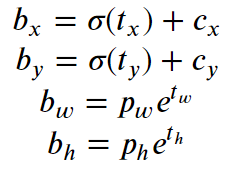

In [34]:
class YOLOLayer(nn.Module):
    def __init__(self, anchors, numClasses, imageSize, yoloLayerIndex, layers, stride):
        super(YOLOLayer, self).__init__()

        # init class variables
        self.anchors = torch.Tensor(anchors)
        self.layerIndex = yoloLayerIndex  
        self.layerIndices = layers  
        self.layerStride = stride  
        self.numOutputLayers = len(layers)  
        self.numAnchors = len(anchors) 
        self.numClasses = numClasses  
        self.numOutputs = numClasses + 5  
        self.numXGridPoints, self.numYGridPoints, self.numGridpoints = 0, 0, 0  
        self.anchorVector = self.anchors / self.layerStride
        self.anchorWH = self.anchorVector.view(1, self.numAnchors, 1, 1, 2)


    def creatGrids(self, numGridPoints =(13, 13), device ='cpu'):
        
        # extract number of x, y gridpoints
        self.numXGridPoints, self.numYGridPoints = numGridPoints  
        # create gridpoints tensor
        self.numGridpoints = torch.tensor(numGridPoints, dtype = torch.float)

        # check if not currently training and build xy offsets 
        if not self.training:
            yv, xv = torch.meshgrid([torch.arange(self.numYGridPoints, device = device), torch.arange(self.numXGridPoints, device = device)])
            self.grid = torch.stack((xv, yv), 2).view((1, 1, self.numYGridPoints, self.numXGridPoints, 2)).float()

        # check if devices do not match and send to device 
        if self.anchorVector.device != device:
            self.anchorVector = self.anchorVector.to(device)
            self.anchorWH = self.anchorWH.to(device)

    def forward(self, prediction, out):
        
        # extract batch size, number of y gridpoints, number of x gridpoints
        batchSize, _, numYGridPoints, numXGridPoints = prediction.shape  

        # check if there is a mismatch in grid sizes and create grids
        if (self.numXGridPoints, self.numYGridPoints) != (numXGridPoints, numYGridPoints):
            self.creatGrids((numXGridPoints, numYGridPoints), prediction.device)

        # reshape prediction accordingly 
        prediction = prediction.view(batchSize, self.numAnchors, self.numOutputs, self.numYGridPoints, self.numXGridPoints).permute(0, 1, 3, 4, 2).contiguous()  

        # check if training is true
        if self.training:
            return prediction
        
        #inference 
        else:
            # extract inference output
            inferenceOutput = prediction.clone() 
            # xy calculation
            inferenceOutput[..., :2] = torch.sigmoid(inferenceOutput[..., :2]) + self.grid  
            # wh yolo method calculation
            inferenceOutput[..., 2:4] = torch.exp(inferenceOutput[..., 2:4]) * self.anchorWH  
            # multiply xywh by layer stride 
            inferenceOutput[..., :4] *= self.layerStride
            # pass inferenceOutput[..., 4:] through sigmoid function
            torch.sigmoid_(inferenceOutput[..., 4:])

            # view [1, 3, 13, 13, 85] as [1, 507, 85]
            return inferenceOutput.view(batchSize, -1, self.numOutputs), prediction  


## Darknet Backbone

In the Darknet class, we leverage a number of methods in order to construct the network's architecture block by block. In YOLOv3, it is easy to modify the network structure by simply modifying the config file provided by the author of YOLOv3, though they also provide different cfg files for different variations of the network such as YOLO3Tiny and YOLOv3SPP. In this implementation we will be using the standard network configuration. 

In the **init** method, we parse the configuration file and generate the relevant network architecture according to the content and order of the parsed file. 

In the **fuse** method, we simply fuse together all of the Conv2d and BatchNorm2d layers throughout model.

In the **forward** method, we simply concatenate the entire module list throughout the for loop in **forwardOnce** and the final result is the output of the YOLO layer. 

In [35]:

# YOLOv3 object detection model
class Darknet(nn.Module):

    def __init__(self, cfg, imageSize =(416, 416), verbose = False):
        super(Darknet, self).__init__()

        # init class variables
        self.moduleDefinitions = parseModel(cfg)
        self.moduleList, self.routs = createModules(self.moduleDefinitions, imageSize, cfg)
        self.yoloLayers = [i for i, m in enumerate(self.moduleList) if m.__class__.__name__ == 'YOLOLayer']  
        self.version = np.array([0, 2, 5], dtype = np.int32)  
        self.numImageSeen = np.array([0], dtype = np.int64)  

    def forward(self, x, augment = False, verbose = False):
        
        # check if augment is false 
        if not augment:
            # pass x through Once
            return self.forwardOnce(x)

        else:  
            # extract image size 
            imageSize = x.shape[-2:]  
            # init scales
            scales = [0.83, 0.67] 
            # init y list  
            output = []

            # iterate through x, flipped (left-right) and scaled x, scaled x 
            for i, xi in enumerate((x, scaleImage(x.flip(3), scales[0], same_shape = False),  scaleImage(x, scales[1], same_shape = False))):
                # pass value through forward once and append output
                output.append(self.forwardOnce(xi)[0])

            # scale
            output[1][..., :4] /= scales[0]  
            # flip left-right
            output[1][..., 0] = imageSize[1] - output[1][..., 0]  
            # scale
            output[2][..., :4] /= scales[1]

            # concatenate output
            output = torch.cat(output, 1)

            return output, None

    def forwardOnce(self, inferenceOutput):

        # init list for yolo output and output 
        yoloLayerOutput, output = [], []

        # iterate through modules in module list
        for i, module in enumerate(self.moduleList):
            # extract module class name 
            name = module.__class__.__name__

            # check if module is of type WeightedFeatureFusion or FeatureConcat
            if name in ['WeightedFeatureFusion', 'FeatureConcat']: 
                # extract inference output 
                inferenceOutput = module(inferenceOutput, output)  
            
            # check if module is of type YOLOLayer
            elif name == 'YOLOLayer':
                # extract and append yolo output 
                yoloLayerOutput.append(module(inferenceOutput, output))

            else: 
                # extract inference output
                inferenceOutput = module(inferenceOutput)

            # append inference output to output list 
            output.append(inferenceOutput if self.routs[i] else [])

        # check if training 
        if self.training:
            return yoloLayerOutput
        
        # inference or test
        else: 
            # extract inference and training output 
            inferenceOutput, trainingOutput = zip(*yoloLayerOutput)  
            # concatenate yolo outputs 
            inferenceOutput = torch.cat(inferenceOutput, 1)  

            return inferenceOutput, trainingOutput

    # Fuse Conv2d + BatchNorm2d layers throughout model
    def fuse(self):
        # init instance of nn.ModuleList()
        fuseList = nn.ModuleList()
        
        # iterate through child modules
        for child in list(self.children())[0]:
           
            # check if child is of type nn.Sequential
            if isinstance(child, nn.Sequential):
           
                # iterate throguh child
                for index, bn in enumerate(child):
           
                    # check if current val is of type nn.modules.batchnorm.BatchNorm2d
                    if isinstance(bn, nn.modules.batchnorm.BatchNorm2d):
                        # fuse this bn layer with the previous conv2d layer
                        conv = child[index - 1]
                        # disable gradient calculation
                        with torch.no_grad():
                            # crate fused convolutional layer 
                            fusedconv = torch.nn.Conv2d(conv.in_channels, conv.out_channels, kernel_size = conv.kernel_size, stride = conv.stride, padding = conv.padding, bias = True)
                            # extract convolutional weights
                            convolutionalWeights = conv.weight.clone().view(conv.out_channels, -1)
                            # extract batch normalization weights 
                            batchNormWeights = torch.diag(bn.weight.div(torch.sqrt(bn.eps + bn.running_var)))
                            # init and reshape fused convolutional layer weights 
                            fusedconv.weight.copy_(torch.mm(batchNormWeights, convolutionalWeights).view(fusedconv.weight.size()))

                            # check if convolutional layer bias is not none 
                            if conv.bias is not None:
                                # extract convolutional spatial bias 
                                convolutionalBias = conv.bias
                            else:
                                # set to zero tensor 
                                convolutionalBias = torch.zeros(conv.weight.size(0))
                            
                            # extract batch normalization spatial bias
                            batchNormBias = bn.bias - bn.weight.mul(bn.running_mean).div(torch.sqrt(bn.running_var + bn.eps))
                            # init and reshape fused convolutional layer bias
                            fusedconv.bias.copy_(torch.mm(batchNormWeights, convolutionalBias.reshape(-1, 1)).reshape(-1) + batchNormBias)

                        child = nn.Sequential(fusedconv, *list(child.children())[index + 1:])
                        break
            
            # append child to fused list 
            fuseList.append(child)
        # assign module list to fuse list 
        self.moduleList = fuseList

## Parse Model Configuration

The following function is responsible for parsing the configuration file and storing every block as a dictionary instance. The attributes of the blocks and their values are stored as key-value pairs in the dictionary, and as we parse through the file, we keep appending these dictionaries to a list blocks. This will return a list of module definitions to be used when constructing the network architecture. 

In [36]:
def parseModel(path):
    # init empty lists
    moduleDefinitions, validLines = [], []
    # read cfg file line by line and store it
    allLines = open(path, 'r').read().split('\n')
    
    for line in allLines:
        # check if line is not empty and do not start with '#'
        if line and not line.startswith("#"):
            # append line and strip all fringe whitespace 
            validLines.append(line.rstrip().lstrip())

    for line in validLines:
        # check if we are at the start of a new block 
        isNewBlock = line.startswith('[')
        
        if isNewBlock:
            # append and populate a dictionary to moduleDefinitions
            moduleDefinitions.append({})
            moduleDefinitions[-1]['type'] = line[1:-1].rstrip()
            # check if module type is convolutional and add batch norm parameter
            if moduleDefinitions[-1]['type'] == 'convolutional':
                # pre-populate with zeros (may be overwritten later)
                moduleDefinitions[-1]['batch_normalize'] = 0  
        
        else:
            # extract key, value pair
            key, val = line.split("=")
            # strip whitespace 
            key = key.rstrip()

            # return a numpy array 
            if key == 'anchors':  
                moduleDefinitions[-1][key] = np.array([float(x) for x in val.split(',')]).reshape((-1, 2))
            # return a regular array 
            elif (key in ['from', 'layers', 'mask']):  
                moduleDefinitions[-1][key] = [int(x) for x in val.split(',')]
            # return a regular array 
            elif (key == 'size' and ',' in val): 
                moduleDefinitions[-1][key] = [int(x) for x in val.split(',')]

            else:
                # strip whitespace 
                val = val.strip()
                # return int/float 
                if val.isnumeric():
                    moduleDefinitions[-1][key] = int(val) if (int(val) - float(val)) == 0 else float(val)   # return int or float
                # return string 
                else:
                    moduleDefinitions[-1][key] = val  

    return moduleDefinitions

## Parse Data Configuration

The following function parses through the data configuration file. It creates an output dictionary and iterates through each line of the coco.data file. It then strips each line of whitespace, extracts the key value pairs, and appends them to the dictionary. 

In [37]:
def parseData(path):
    
    # init output dictionary 
    options = dict()

    # open are read data file into lines 
    with open(path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        # strip whitespace 
        line = line.strip()
        # check if line is empty or starts with a '#' (indicates a comment)
        if line == '' or line.startswith('#'): continue
        # extract key, value pair 
        key, val = line.split('=')
        # add key,value pair to dictionary 
        options[key.strip()] = val.strip()

    return options

## Build Modules

In order to create the building blocks of this network, we utilise the output of the parsing function (moduleDefinitions) to construct a number of PyTorch modules as dictated by the configuration list. This function essentially iterates over the list of blocks and creates a PyTorch module for each block as we go. The output of this function will return a list that contains an nn.Module object called an nn.ModuleList. The nn.Sequential class is also used to sequentially execute a number of nn.Module objects. This is useful as some blocks may contain more than one layer. nn.Sequential allows us to attatch these layers together.  

In constructing the network, there are six main module types to consider. They are as follows:

1. **Convolutional Layer**

    The convolutional layer is a layer that contains units whose receptive fields cover a patch of the previous layer. The weight vector (the set of adaptive parameters) of such a unit is often called a filter.

    In defining the convolutional layer(s), it is important to define the kernel dimensions. This is pretty much taken care of by the parameters included in the cfg file, however we must also keep track of the number of filters present in each previous layer, therefore providing us with the depth of the feature map. It is also important to add the batch normalize layer, pad layer, as well as the leaky activation function. 

        
        
2. **Maxpool Layer**

    The Max Pooling layer is a pooling operation that extracts the maximum value in each patch of a feature map, and then down-samples it to highlight the most present feature in the patch. It is essentially a sample-based discretization process that aims to reduce dimensionality and allow for assumptions to be made about features contained in the sub-regions. In YOLOv3, however, max pooling is not used for downsampling. Instead, a 3X3 convolutional kernel is used with a step size of 2. This takes place a total of five times. 


3. **Upsample Layer**

    The upsample layer upsamples the feature map in the previous layer by a factor of stride using bilinear upsampling.
    
   

4. **Route Layer**

    The route layer plays a very important role in this network. It preforms the equivalent role of fusing together previous feature maps. If its attribute layer has only one value, then the route layer will output the feature maps of the layer indexed by that value. If, however, the attribute layer has two values then it will output the concatenated feature maps of the layers indexed by it's values along the depth dimension. It is also important to note that if there is a convolutional layer present right in front of a route layer, then the kernel is applied on the feature maps of previous layers, precisely the ones the route layer brings. Therefore, we need to keep a track of the number of filters in not only the previous layer, but each one of the preceding layers. As we iterate, we append the number of output filters of each block to the output_filters variable.



5. **Shortcut Layer**

    The shortcut layer is used to optimise the large network structure in order to provide faster training times and better convergence scores. It is essentially a skip connection that superimposes the value of the network without changing the size of the feature map, and so you will find that the input and output sizes have not changed before and after the shortcut layer. The output of the shortcut layer is found by adding feature maps.


6. **YOLO Layer**
    
   The YOLO layer corresponds to the detection layer. YOLOv3 makes prediction across 3 different scales. The detection layer is used make detection at feature maps of three different sizes, having strides 32, 16, 8 respectively. This means, with an input of 416 x 416, we make detections on scales 13 x 13, 26 x 26 and 52 x 52. Generally, stride of any layer in the network is equal to the factor by which the output of the layer is smaller than the input image to the network.

    The network downsamples the input image until the first detection layer, where a detection is made using feature maps of a layer with stride 32. Further, layers are upsampled by a factor of 2 and concatenated with feature maps of a previous layers having identical feature map sizes. Another detection is now made at layer with stride 16. The same upsampling procedure is repeated, and a final detection is made at the layer of stride 8. At each scale, each cell predicts 3 bounding boxes using 3 anchors, making the total number of anchors used 9. This is at the heart of YOLOv3's multi-scale detection. The use of 3 scales is to strengthen the detection of small targets. A relatively large feature map is used to detect relatively small targets, and a small feature map is responsible for detecting large targets.
    
    

In [38]:
def createModules(moduleDefinitions, imgSize, cfg):
    
    # check if image size is an integer or tuple, and expand it if necessary 
    imgSize = [imgSize] * 2 if isinstance(imgSize, int) else imgSize  
    # extract hyperparameters from config file (unused)
    trainingHyperparms = moduleDefinitions.pop(0)  
    # init output filters
    outputFilters = [3]  
    # init module list 
    moduleList = nn.ModuleList()
    # init routing layers (list of layers that route to deeper layers)
    routingLayers = []  
    # init yolo index
    yoloIndex = -1

    # iterate through parsed cfg file and construct modules 
    for idx, currModule in enumerate(moduleDefinitions):
        modules = nn.Sequential()

        if currModule['type'] == 'convolutional':
            # extract batch normalize value 
            isBatchNormalize = currModule['batch_normalize']
            # extract filters value 
            filters = currModule['filters']
            # extract kernel size value
            kernelSize = currModule['size']   
            # extract stride value
            stride = currModule['stride'] if 'stride' in currModule else (currModule['stride_y'], currModule['stride_x'])
            # create convolutional layer 
            convLayer = nn.Conv2d(in_channels = outputFilters[-1], out_channels = filters, kernel_size = kernelSize, stride = stride, padding = kernelSize // 2 if currModule['pad'] else 0, groups = currModule['groups'] if 'groups' in currModule else 1, bias = not isBatchNormalize)
            # add convolutional layer 
            modules.add_module('Conv2d', convLayer)

            # if batch normalise 
            if isBatchNormalize:
                # create batch norm layer 
                batchNormLayer = nn.BatchNorm2d(filters, momentum = 0.03, eps = 1E-4)
                # add batch norm layer 
                modules.add_module('BatchNorm2d', batchNormLayer)
            
            else:
                # detection output that goes into YOLO layer 
                routingLayers.append(idx)  

            # leaky activation
            if currModule['activation'] == 'leaky':  
                # creat leaky layer 
                leakyLayer = nn.LeakyReLU(0.1, inplace = True)
                # add leaky layer 
                modules.add_module('activation', leakyLayer)

        elif currModule['type'] == 'upsample':
            # create upsample layer 
            modules = nn.Upsample(scale_factor = currModule['stride'])

        elif currModule['type'] == 'route':  
            # extract layers 
            layers = currModule['layers']
            # extract filters 
            filters = sum([outputFilters[l + 1 if l > 0 else l] for l in layers])
            # extend routing layers
            routingLayers.extend([idx + l if l < 0 else l for l in layers])
            # creat route layer using FeatureConcat class
            modules = FeatureConcat(layers = layers)

        elif currModule['type'] == 'shortcut':
            # extract layers 
            layers = currModule['from']
            # extract filters 
            filters = outputFilters[-1]
            # extend routing layers 
            routingLayers.extend([idx + l if l < 0 else l for l in layers])
            # create shortcut layer using WeightedFeatureFusion class
            modules = WeightedFeatureFusion(layers = layers, weight ='weights_type' in currModule)

        elif currModule['type'] == 'yolo':
            # increment yolo index 
            yoloIndex += 1
            # init stride list 
            stride = [32, 16, 8]
            # extract layers 
            layers = currModule['from'] if 'from' in currModule else []
            # create yolo layer 
            modules = YOLOLayer(anchors = currModule['anchors'][currModule['mask']], numClasses = currModule['classes'],   imageSize = imgSize,   yoloLayerIndex = yoloIndex,   layers = layers, stride = stride[yoloIndex])

            # init preceding Conv2d() bias 
            j = layers[yoloIndex] if 'from' in currModule else -1
            bias_ = moduleList[j][0].bias  
            bias = bias_[:modules.numOutputs * modules.numAnchors].view(modules.numAnchors, -1)  
            bias[:, 4] += -4.5  
            bias[:, 5:] += math.log(0.6 / (modules.numClasses - 0.99))  
            moduleList[j][0].bias = torch.nn.Parameter(bias_, requires_grad = bias_.requires_grad)

        # append modules to module list 
        moduleList.append(modules)
        # append filters to output filters 
        outputFilters.append(filters)
    
    # init binary routing layers 
    binaryRoutingLayers = [False] * (idx + 1)
    # iterate through routing layers and set those indices to true in binary routing layers list 
    for idx in routingLayers:
        binaryRoutingLayers[idx] = True

    return moduleList, binaryRoutingLayers

## Load DarkNet Weights

The following function allows us to parse and load weights into our model. 

The official weights file is a binary file that contains weights stored in a serial fashion. It is important that they are parsed precisely such that no mistakes are made when loading them. It is also important to note that the weights in this file only belong to the batch normlaisation layer or convolutional layer. They are stored exactly in the same order as they appear in the configuration file, and as such when a batch normalisation layer appears in a convolutional block, there are no biases. However, when there is no batch normalization layer, bias weights must be read from the file.  

The first five values stored in the file represent the header, and the remaining values are weights. The weights are loaded in a numpy array and we then iterate through the modules and module definitions and load the weights into the modules of our network.

Inside the loop, we must first check whether the convolutional block has a batch normalisation layer and load the weights. This is helped by the ptr variable that allows us to keep track of where we are in the weights array. If the convolutional block does not have a batch normalisation layer, we load the biases of the convolutional layer, and then load the convolutional layer's weights in the following block of code. 

In [39]:
def loadDarkNetWeights(self, weights, cutoff = -1):

    file = Path(weights).name
 
    # read weights file
    with open(weights, 'rb') as f:
        self.version = np.fromfile(f, dtype=np.int32, count=3)   
        self.seen = np.fromfile(f, dtype=np.int64, count=1) 

        weights = np.fromfile(f, dtype=np.float32)  

    ptr = 0
    
    for idx, (moduleDef, module) in enumerate(zip(self.moduleDefinitions[:cutoff], self.moduleList[:cutoff])):
        if moduleDef['type'] == 'convolutional':
            # extract conv
            conv = module[0]

            # load batch normalization bias, weights, running mean and running variance
            if moduleDef['batch_normalize']:

                # extract batch normalize 
                batchNormalize = module[1]

                # extract number of biases
                numBiases = batchNormalize.bias.numel() 

                # load bias
                batchNormBias = torch.from_numpy(weights[ptr:ptr + numBiases])
                
                batchNormalize.bias.data.copy_(torch.from_numpy(weights[ptr:ptr + numBiases]).view_as(batchNormalize.bias))
                ptr += numBiases

                # load weight
                batchNormWeight = torch.from_numpy(weights[ptr:ptr + numBiases])
                
                batchNormalize.weight.data.copy_(torch.from_numpy(weights[ptr:ptr + numBiases]).view_as(batchNormalize.weight))
                ptr += numBiases

                # load running mean 
                batchNormRunMean = torch.from_numpy(weights[ptr:ptr + numBiases])

                batchNormalize.running_mean.data.copy_(torch.from_numpy(weights[ptr:ptr + numBiases]).view_as(batchNormalize.running_mean))
                ptr += numBiases

                # load running var 
                batchNormRunVar = torch.from_numpy(weights[ptr:ptr + numBiases])

                batchNormalize.running_var.data.copy_(torch.from_numpy(weights[ptr:ptr + numBiases]).view_as(batchNormalize.running_var))
                ptr += numBiases

                # cast into dimensions of the model 
                batchNormBias = batchNormBias.view_as(batchNormalize.bias)
                batchNormWeight = batchNormWeight.view_as(batchNormalize.weight)
                batchNormRunMean = batchNormRunMean.view_as(batchNormalize.running_mean)
                batchNormRunVar = batchNormRunVar.view_as(batchNormalize.running_var)

                # copy data to model 
                batchNormalize.bias.data.copy_(batchNormBias)
                batchNormalize.weight.data.copy_(batchNormWeight)
                batchNormalize.running_mean.data.copy_(batchNormRunMean)
                batchNormalize.running_var.data.copy_(batchNormRunVar)

            else:
                # extract number of biases 
                numBiases = conv.bias.numel()
                # load bias 
                convBias = torch.from_numpy(weights[ptr:ptr + numBiases])
                # cast into dimensions of model
                convBias = convBias.view_as(conv.bias)
                # copy data to model 
                conv.bias.data.copy_(convBias)
                # increment pointer 
                ptr += numBiases

            # load conv weights
            # extract number of weights 
            numWeights = conv.weight.numel()  
            # load weights 
            convWeights = torch.from_numpy(weights[ptr:ptr + numWeights])
            # cast into dimensions of model 
            convWeights = convWeights.view_as(conv.weight)
            # copy data to model 
            conv.weight.data.copy_(convWeights)
            # increment pointer 
            ptr += numWeights


# Detect

In [40]:
def detect():
    
    # init image size
    imageSize = 512
    # init output directory 
    out = "output"
    # init source directory
    source = "data/samples"
    # init weights directory
    weights = "weights/yolov3.weights"
    # init cfg file path 
    cfgFile = "cfg/yolov3.cfg"
    
    # init device to GPU or CPU based on availbility
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # delete output foler
    if os.path.exists(out):
        shutil.rmtree(out)  
    
    # make new output folder
    os.makedirs(out)  

    # init model
    model = Darknet(cfgFile, imageSize)
    
    # load pytorch weights
    if weights.endswith('.pt'):  
        model.load_state_dict(torch.load(weights, map_location=device)['model'])
        
    # load darknet weights 
    else:  
        loadDarkNetWeights(model, weights)

    # init evaluation mode
    model.to(device).eval()

    # init dataloader
    dataset = LoadImages(source, imageSize = imageSize)

    # read names
    with open("data/coco.names", 'r') as f:
        lines = f.read().split('\n')
    
    # remove empty lines
    names = list(filter(None, lines))  
    
    # init random colours 
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]

    # init img
    img = torch.zeros((1, 3, imageSize, imageSize), device = device)  
    
    # run once
    _ = model(img.float()) 
    
    # iterate through images in dataset
    for path, img, im0s in dataset:
        
        # get image
        img = torch.from_numpy(img).to(device)
        # convert image to float
        img = img.float()  
        # 0-255 to 0.0-1.0
        img /= 255.0  
        
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # pass image through model and extract prediction
        pred = model(img, augment = False)[0]

        # apply non-max supression
        pred = NMS(pred, 0.3, 0.6, multi_label = False, classes = None, agnostic = False)

        # process detections for image
        for idx, detections in enumerate(pred):  
            p, im0 = path, im0s

            saveDir = str(Path(out) / Path(p).name)

            if detections is not None and len(detections):
                # rescale boxes from image size to im0 size
                detections[:, :4] = scaleCoordinates(img.shape[2:], detections[:, :4], im0.shape).round()

                # write results
                for *xyxy, conf, cls in reversed(detections):
                    # add bounding box to image
                    label = '%s %.2f' % (names[int(cls)], conf)
                    plotBox(xyxy, im0, label = label, color = colors[int(cls)])

            # save images with detections
            cv2.imwrite(saveDir, im0)

In [41]:
# disable gradients
with torch.no_grad():
    detect()

/home/nyuad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)


# Test

In [42]:
def test(cfg = "cfg/yolov3.cfg", data = "data/coco2017.data", weights = "weights/yolov3.weights", batchSize = 16, imgSize = 416, confidenceThreshold = 0.001, iouThreshold = 0.6, augment= True, model = None, dataloader= None, multi_label = True):

    # check if not training 
    if model is None:
       
        # inite device to gpu or cpu depending on availability
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # set verbose to true
        verbose = True
        # set isTraining to false
        isTraining = False
        
        # remove previous file
        for f in glob.glob('test_batch*.jpg'):
            os.remove(f)

        # init model
        model = Darknet(cfg, imgSize)

        # load weights in pytorch format
        if weights.endswith('.pt'): 
            model.load_state_dict(torch.load(weights, map_location=device)['model'])
            
        # load weights in darknet format
        else:  
            loadDarkNetWeights(model, weights)

        # fuse model 
        model.fuse()
        # send model to device
        model.to(device)
        
        
    else: 
        # set isTraining to true
        isTraining = True
        # get device
        device = next(model.parameters()).device
        # set verbose to false
        verbose = False

    # parse data file
    data = parseData(data)
    # extract number of classes
    numClasses =  int(data['classes'])  
    # extract test path
    testPath = data['valid']  
    
    # read names
    with open(data['names'], 'r') as f:
        names = f.read().split('\n')
        
    # extract list of class names and remove empty lines
    classNames = list(filter(None, names))  

    # init iou vector for mAP@0.5:0.95
    iouVector = torch.linspace(0.5, 0.95, 10).to(device)  
    iouVector = iouVector[0].view(1) 
    niou = iouVector.numel()

    # init data loader
    if dataloader is None:
        dataset = LoadImagesAndLabels(testPath, imgSize, batchSize, pad = 0.5)
        batchSize = min(batchSize, len(dataset))
        dataloader = DataLoader(dataset, batch_size = batchSize, num_workers= min([os.cpu_count(), batchSize if batchSize > 1 else 0, 8]), pin_memory= True, collate_fn = dataset.collate_fn)

    # init number of seen images
    seen = 0
    
    # configure model in evaluation mode
    model.eval()
    
    # run once
    _ = model(torch.zeros((1, 3, imgSize, imgSize), device = device)) if device.type != 'cpu' else None  
    
    s = ('%20s' + '%10s' * 6) % ('Class', 'Images', 'Targets', 'P', 'R', 'mAP@0.5', 'F1')
    
    # init precision, recall, F1, meanPrecision, meanRecall, mAP, meanF1
    precision, recall, F1, meanPrecision, meanRecall, mAP, meanF1 = 0., 0., 0., 0., 0., 0., 0.
    # init loss
    loss = torch.zeros(3, device = device)
    # init testStatistics, AP, APClass
    testStatistics, AP, APClass = [], [], []

    for batchIdx, (imgs, targets, paths, shapes) in enumerate(tqdm(dataloader, desc = s)):
        # convert image to float and squash range from 0-255 to 0.0-1.0
        imgs = imgs.to(device).float() / 255.0  
        # send targets to device
        targets = targets.to(device)
        # extract number of batches, channels, height, width from image shape
        numBatches, channels, height, width = imgs.shape  
        # init whwh tensor
        whwh = torch.Tensor([width, height, width, height]).to(device)

        # disable gradients and run model
        with torch.no_grad():
            # extract inference and training outputs
            inferenceOutput, trainingOutput = model(imgs, augment= augment)  

            # check if training and we have loss hyperparameters
            if isTraining: 
                # calculate and sum losses 
                loss += getLosses(trainingOutput, targets, model)[1][:3] 

            # perfrom non-maximum supression
            output = NMS(inferenceOutput, conf_thres= confidenceThreshold, iou_thres= iouThreshold, multi_label = multi_label)

        # calculate statistics per image
        for statIdx, pred in enumerate(output):
            # extract labels
            labels = targets[targets[:, 0] == statIdx, 1:]
            # calculate number of labels
            numLabels = len(labels)
            # extract target classes
            targetClass = labels[:, 0].tolist() if numLabels else []  
            # increment seen
            seen += 1

            if pred is None:
                if numLabels:
                    testStatistics.append((torch.zeros(0, niou, dtype = torch.bool), torch.Tensor(), torch.Tensor(), targetClass))
                continue


            # clip bounding box coordinates to image bounds
            pred[:, 0].clamp_(0, width)  # x1
            pred[:, 1].clamp_(0, height)  # y1
            pred[:, 2].clamp_(0, width)  # x2
            pred[:, 3].clamp_(0, height)  # y2

            # set all predictions as incorrect
            correct = torch.zeros(pred.shape[0], niou, dtype = torch.bool, device = device)
            
            # check if numLabels is larger than zero
            if numLabels:
                detected = []  
                targetClassTensor = labels[:, 0]

                # target boxes
                tbox = xywh2xyxy(labels[:, 1:5]) * whwh

                # iterate through target classes
                for cls in torch.unique(targetClassTensor):
                    # extract target indices
                    targetIndices = (cls == targetClassTensor).nonzero().view(-1) 
                    # extract prediction indices
                    predictionIndices = (cls == pred[:, 5]).nonzero().view(-1)  

                    # search for detections
                    if predictionIndices.shape[0]:
                        # best IOUs and indices
                        ious, i = boxIOU(pred[predictionIndices, :4], tbox[targetIndices]).max(1)  
                        
                        # append detections
                        for j in (ious > iouVector[0]).nonzero():
                            detectedTarget = targetIndices[i[j]]  
                            if detectedTarget not in detected:
                                detected.append(detectedTarget)
                                correct[predictionIndices[j]] = ious[j] > iouVector  
                                if len(detected) == numLabels:  
                                    break

            # append statistics (correct, conf, pcls, tcls)
            testStatistics.append((correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), targetClass))

        # plot images
        if batchIdx < 1:
            f = 'test_batch%g_gt.jpg' % batchIdx  
            # ground truth
            plotImages(imgs, targets, paths = paths, names= classNames, fname = f)  
            f = 'test_batch%g_pred.jpg' % batchIdx
            # predictions
            plotImages(imgs, convertToTarget(output, width, height), paths= paths, names= classNames, fname = f)  

    testStatistics = [np.concatenate(x, 0) for x in zip(*testStatistics)] 
    
    # compute statistics 
    if len(testStatistics):
        # calculate precision, recall, AP, F1, APClass
        precision, recall, AP, F1, APClass = getAPClass(*testStatistics)
        
        if niou > 1:
            precision, recall, AP, F1 = precision[:, 0], recall[:, 0], AP.mean(1), AP[:, 0]  
        
        # calculate mean values 
        meanPrecision, meanRecall, mAP, meanF1 = precision.mean(), recall.mean(), AP.mean(), F1.mean()
        # number of targets per class
        numTargets = np.bincount(testStatistics[3].astype(np.int64), minlength = numClasses) 
    else:
        # init number of targets per class to tensor filled with ones
        numTargets = torch.zeros(1)
   
    pf = '%20s' + '%10.3g' * 6 
    print(pf % ('all', seen, numTargets.sum(), meanPrecision, meanRecall, mAP, meanF1))

    # print results per class
    if numClasses > 1 and len(testStatistics):
        for i, currClass in enumerate(APClass):
            print(pf % (classNames[currClass], seen, numTargets[currClass], precision[i], recall[i], AP[i], F1[i]))



    # return results
    mAPs = np.zeros(numClasses) + mAP
    for i, currClass in enumerate(APClass):
        mAPs[currClass] = AP[i]
        
    return (meanPrecision, meanRecall, mAP, meanF1, *(loss.cpu() / len(dataloader)).tolist()), mAPs

In [43]:
test()

caching labels (4952 found, 48 missing, 0 empty, 0 duplicate, for 5000 images): 100%|██████████| 5000/5000 [00:24<00:00, 203.46it/s]
/home/mmvc/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
               Class    Images   Targets         P         R   mAP@0.5        F1: 100%|██████████| 313/313 [02:18<00:00,  2.27it/s]


                 all     5e+03  3.63e+04     0.293     0.755     0.642     0.417
              person     5e+03  1.08e+04     0.278     0.852     0.752     0.419
             bicycle     5e+03       314     0.246     0.624     0.522     0.352
                 car     5e+03  1.92e+03     0.233     0.735     0.603     0.354
          motorcycle     5e+03       367     0.293     0.828      0.72     0.433
            airplane     5e+03       143     0.507     0.888     0.873     0.646
                 bus     5e+03       283     0.387      0.89     0.854     0.539
               train     5e+03       190     0.536     0.942     0.923     0.683
               truck     5e+03       414     0.285     0.766     0.611     0.415
                boat     5e+03       424     0.213     0.653     0.458     0.321
       traffic light     5e+03       634     0.232     0.675      0.51     0.345
        fire hydrant     5e+03       101     0.584     0.842     0.845     0.689
           stop sign     5e+

((0.2930413094653943,
  0.7549933037465265,
  0.6417110127569559,
  0.41737028529884934,
  0.0,
  0.0,
  0.0),
 array([    0.75154,     0.52201,     0.60296,      0.7201,     0.87278,     0.85369,     0.92287,     0.61114,     0.45805,     0.50988,     0.84497,      0.7242,     0.80594,     0.46499,     0.49853,     0.93477,     0.84596,     0.83371,     0.73063,     0.69697,     0.83992,     0.94541,     0.88184,     0.88277,
            0.36018,     0.67071,     0.32888,     0.54158,     0.66835,     0.86056,     0.47288,     0.59828,     0.58727,     0.54961,     0.65875,     0.68167,     0.78438,     0.65787,     0.79721,     0.54979,     0.56239,     0.60393,     0.51677,     0.35916,      0.3254,     0.63381,     0.47077,     0.35534,
            0.68028,     0.54023,     0.44693,      0.4176,     0.65691,     0.76454,     0.68651,     0.69008,      0.5567,      0.7119,     0.58726,     0.79868,     0.54886,       0.886,     0.85758,     0.81008,     0.81268,     0.50874,     0.7

# Train

In [44]:
# init training hyperparameters
trainHyperParams = {
       'giou': 3.54,  # giou loss gain
       'cls': 37.4,  # cls loss gain
       'cls_pw': 1.0,  # cls BCELoss positive_weight
       'obj': 64.3,  # obj loss gain (*= img_size/320 if img_size != 320)
       'obj_pw': 1.0,  # obj BCELoss positive_weight
       'iou_t': 0.20,  # iou training threshold
       'lr0': 0.01,  # initial learning rate (SGD = 5E-3, Adam = 5E-4)
       'lrf': 0.0005,  # final learning rate (with cos scheduler)
       'momentum': 0.937,  # SGD momentum
       'weight_decay': 0.0005,  # optimizer weight decay
       'fl_gamma': 0.0,  # focal loss gamma (efficientDet default is gamma = 1.5)
       'hsv_h': 0.0138,  # image HSV-Hue augmentation (fraction)
       'hsv_s': 0.678,  # image HSV-Saturation augmentation (fraction)
       'hsv_v': 0.36,  # image HSV-Value augmentation (fraction)
       'degrees': 1.98 * 0,  # image rotation (+/- deg)
       'translate': 0.05 * 0,  # image translation (+/- fraction)
       'scale': 0.05 * 0,  # image scale (+/- gain)
       'shear': 0.641 * 0} # image shear (+/- deg)

In [45]:
# init directories
weightDirectory = 'weights' + os.sep  
last = weightDirectory + 'last.pt'
best = weightDirectory + 'best.pt'
resultOutput = 'results.txt'

In [46]:
def train(trainHyperParams):

    # init config file path
    configFilePath = "cfg/yolov3.cfg"
    # init data file path
    dataFilePath = "data/coco2017.data"
    # init number of epochs
    numEpochs = 300  
    # init batch size 
    trainBatchSize = 16
    # init accumulation interval before optimizer update
    accumulationInterval = max(round(64 / trainBatchSize), 1) 
    # init image size
    imageSize = [416]
    # extend image size to (min, max, test)
    imageSize.extend([imageSize[-1]] * (3 - len(imageSize)))  
    # init device to gpu or cpu depending on availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # init min, max, and test image sizes
    minImgSize, maxImgSize, testImgSize = imageSize  
    # init grid size
    gridSize = 32  # (pixels) grid size
    
    # check if min image size and max image size are the same 
    if minImgSize == maxImgSize:
        # change sizes for multiscale training
        minImgSize //= 1.5
        maxImgSize //= 0.667

    # calculate minimum and maximum grid size
    minGridSize, maxGridSize = minImgSize // gridSize, maxImgSize // gridSize
    # calculate minimum and maximum image size
    minImgSize, maxImgSize = int(minGridSize * gridSize), int(maxGridSize * gridSize)
    # init image size with max image size
    imgSize = maxImgSize  

    # configure run
    seed = 0
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # reduce randomness 
    if seed == 0:
        cudnn.deterministic = False
        cudnn.benchmark = True

    # parse data
    parsedData = parseData(dataFilePath)
    # extract training path
    trainingPath = parsedData['train']
    # extract testing path
    testingPath = parsedData['valid']
    # extract number of classes
    numClasses =  int(parsedData['classes'])  
    # update coco-tuned hyp['cls'] to current datas
    trainHyperParams['cls'] *= numClasses / 80 

    # delete previous results
    for file in glob.glob('*_batch*.jpg') + glob.glob(resultOutput):
        os.remove(file)

    # init model
    model = Darknet(configFilePath).to(device)

    # init optimizer parameter groups
    paramGroupZero, paramGroupOne, paramGroupTwo = [], [], []  # optimizer parameter groups
    
    # iterate through model's named parameters
    for key, value in dict(model.named_parameters()).items():
        
        if '.bias' in key:
            # apply biases 
            paramGroupTwo += [value] 
            
        elif 'Conv2d.weight' in key:
            # apply weight decay
            paramGroupOne += [value]
            
        else:
            # apply all other values
            paramGroupZero += [value] 

    # init optimizer 
    optimizer = optim.Adam(paramGroupZero, lr = trainHyperParams['lr0'])
    # add weight decay
    optimizer.add_param_group({'params': paramGroupOne, 'weight_decay': trainHyperParams['weight_decay']}) 
    # add biases
    optimizer.add_param_group({'params': paramGroupTwo}) 
    # delete parameter groups
    del paramGroupZero, paramGroupOne, paramGroupTwo

    beginningEpoch = 0
    bestFitnessScore = 0.0
    
    lf = lambda x: (((1 + math.cos(x * math.pi / numEpochs)) / 2) ** 1.0) * 0.95 + 0.05  # cosine
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda = lf)
    scheduler.last_epoch = beginningEpoch - 1 
    
    # init dataset
    dataset = LoadImagesAndLabels(trainingPath, imgSize, trainBatchSize, augment = True, hyp = trainHyperParams, rect = False)

    # init data loader
    trainBatchSize = min(trainBatchSize, len(dataset))
    numWorkers = min([os.cpu_count(), trainBatchSize if trainBatchSize > 1 else 0, 8])  # number of workers
    dataLoader = torch.utils.data.DataLoader(dataset, batch_size = trainBatchSize, num_workers = numWorkers, shuffle = True,  pin_memory = True, collate_fn = dataset.collate_fn)

    # init data loader used for testing
    testDataLoader = torch.utils.data.DataLoader(LoadImagesAndLabels(testingPath, testImgSize, trainBatchSize, hyp = trainHyperParams, rect = True), batch_size = trainBatchSize, num_workers = numWorkers, pin_memory = True, collate_fn = dataset.collate_fn)

    # init model parameters (number of classes,hyperparameters, GIOU loss ratio)
    model.nc = numClasses  
    model.hyp = trainHyperParams  
    model.gr = 1.0  

    # extract number of batches
    numBatches = len(dataLoader)  
    # calculate burn in iterations
    burnInVal = max(3 * numBatches, 500)  
    # init mAPs per class
    mAPs = np.zeros(numClasses)  
    # init results ('P', 'R', 'mAP', 'F1', 'val GIoU', 'val Objectness', 'val Classification')
    results = (0, 0, 0, 0, 0, 0, 0) 
    
    beginningTime = time.time()
    
    # iterate through epochs
    for epoch in range(beginningEpoch, numEpochs):
        
        # set model to training mode
        model.train()
        # init mean loss
        meanLoss = torch.zeros(4).to(device)  # mean losses
        
        print(('\n' + '%10s' * 8) % ('Epoch', 'gpu_mem', 'GIoU', 'obj', 'cls', 'total', 'targets', 'img_size'))
        
        # create progress bar
        progressBar = tqdm(enumerate(dataLoader), total = numBatches)  # progress bar

        # iterate through batches
        for batchIdx, (imgs, targets, paths, null) in progressBar:
            # update number of completed batches
            numCompletedBatches = batchIdx + numBatches * epoch  
            # convert to float and squash range from 0-255 to 0.0-1.0
            imgs = imgs.to(device).float() / 255.0 
            # send targets to device
            targets = targets.to(device)

            # burn-in
            if numCompletedBatches <= burnInVal:
                
                # x interpolation
                xi = [0, burnInVal]
                
                # giou loss ratio
                model.gr = np.interp(numCompletedBatches, xi, [0.0, 1.0])  
                
                accumulationInterval = max(1, np.interp(numCompletedBatches, xi, [1, 64 / trainBatchSize]).round())
                for j, x in enumerate(optimizer.param_groups):
                    # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
                    x['lr'] = np.interp(numCompletedBatches, xi, [0.1 if j == 2 else 0.0, x['initial_lr'] * lf(epoch)])
                    x['weight_decay'] = np.interp(numCompletedBatches, xi, [0.0, trainHyperParams['weight_decay'] if j == 1 else 0.0])
                    
                    if 'momentum' in x:
                        x['momentum'] = np.interp(numCompletedBatches, xi, [0.9, trainHyperParams['momentum']])

            # multi-scale
            if numCompletedBatches / accumulationInterval % 1 == 0:  
                # adjust image size
                imgSize = random.randrange(minGridSize, maxGridSize + 1) * gridSize
                
            # calculate scale factor
            scaleFactor = imgSize / max(imgs.shape[2:])  
            
            if scaleFactor != 1:
                newShape = [math.ceil(x * scaleFactor / gridSize) * gridSize for x in imgs.shape[2:]]  # new shape (stretched to 32-multiple)
                imgs = F.interpolate(imgs, size = newShape, mode ='bilinear', align_corners = False)

            # forward pass model
            pred = model(imgs)

            # calculate loss
            loss, lossItems = getLosses(pred, targets, model)
            
            if not torch.isfinite(loss):
                print('WARNING: non-finite loss, ending training ', lossItems)
                return results

            # scale loss
            loss *= trainBatchSize / 64  
            # backwards
            loss.backward()

            # optimize
            if numCompletedBatches % accumulationInterval == 0:
                optimizer.step()
                optimizer.zero_grad()

           # update mean loss
            meanLoss = (meanLoss * batchIdx + lossItems) / (batchIdx + 1) 
            
            # calculate gpu memory
            GPUmemory = '%.3gG' % (torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0)  
            
            # set progress bar description
            s = ('%10s' * 2 + '%10.3g' * 6) % ('%g/%g' % (epoch, numEpochs - 1), GPUmemory, *meanLoss, len(targets), imgSize)
            progressBar.set_description(s)

            # plot images
            if numCompletedBatches < 1:
                f = 'train_batch%g.jpg' % batchIdx  
                res = plotImages(images = imgs, targets = targets, paths = paths, fname = f)

        # update scheduler
        scheduler.step()

        # process epoch results
        isLastEpoch = epoch + 1 == numEpochs
        
        if isLastEpoch: 
            results, mAPs = test(configFilePath, dataFilePath, batchSize = trainBatchSize, imgSize = testImgSize, model = model, dataloader = testDataLoader, multi_label = numCompletedBatches > burnInVal)

        # write results
        with open(resultOutput, 'a') as f:
            f.write(s + '%10.3g' * 7 % results + '\n') 

        # update best mAP
        arg = np.array(results).reshape(1, -1)
        
        # init weights for [P, R, mAP, F1]@0.5 
        w = [0.0, 0.01, 0.99, 0.00] 
        # fitness score is  weighted combination of [P, R, mAP, F1]
        fitnessScore = (arg[:, :4] * w).sum(1) 

         
        if fitnessScore > bestFitnessScore:
            bestFitnessScore = fitnessScore

        # save model
        if isLastEpoch:
            with open(resultOutput, 'r') as f:  
                # create checkpoint
                ckpt = {'epoch': epoch, 'best_fitness': bestFitnessScore, 'training_results': f.read(), 'model': model.module.state_dict() if type(model) is nn.parallel.DistributedDataParallel else model.state_dict(), 'optimizer': None if isLastEpoch else optimizer.state_dict()}

            # save last and best checkpoint and then delete
            torch.save(ckpt, last)
            if (bestFitnessScore == fitnessScore) and not isLastEpoch:
                torch.save(ckpt, best)
            del ckpt


    plotResults()  
    return results

In [47]:
train(trainHyperParams)

caching labels (117266 found, 1021 missing, 0 empty, 0 duplicate, for 118287 images): 100%|██████████| 118287/118287 [09:27<00:00, 208.35it/s]
caching labels (4952 found, 0 missing, 48 empty, 0 duplicate, for 5000 images): 100%|██████████| 5000/5000 [00:00<00:00, 21786.67it/s]


     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size



  0%|          | 0/7393 [00:08<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 7.79 GiB total capacity; 6.68 GiB already allocated; 5.75 MiB free; 6.73 GiB reserved in total by PyTorch)

In [ ]:
plotResults()

In [ ]:
Image(filename ='results.png', width = 800)